In [1]:
# Run only once to install the dependencies
import sys

!pip install -q rdflib networkx matplotlib
!{sys.executable} -m pip install rdflib networkx matplotlib --user

     |████████████████████████████████| 235kB 4.6MB/s 
     |████████████████████████████████| 51kB 5.3MB/s 


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

from rdflib import Graph as RDFGraph
from rdflib.extras.external_graph_libs import rdflib_to_networkx_graph
from networkx import Graph as NXGraph

In [3]:
tkgs = {'2017': 'https://raw.githubusercontent.com/rossanez/KGen/master/examples/cs/ISWC/2017/merged_kg.ttl',
        '2018': 'https://raw.githubusercontent.com/rossanez/KGen/master/examples/cs/ISWC/2018/merged_kg.ttl',
        '2019': 'https://raw.githubusercontent.com/rossanez/KGen/master/examples/cs/ISWC/2019/merged_kg.ttl'}

nxgs = {}
for tkg in tkgs.keys():
    rdfg = RDFGraph()
    rdfg.parse(tkgs[tkg], format='turtle')
    print('Loaded TKG {}'.format(tkg))
    nxg = rdflib_to_networkx_graph(rdfg)
    print(' - Converted to complex network: {} nodes and {} edges'.format(nxg.number_of_nodes(), nxg.number_of_edges()))
    print(' -- Network density: {}'.format(nx.density(nxg)))
    nxgs[tkg] = nxg

Loaded TKG 2017
 - Converted to complex network: 7921 nodes and 10779 edges
 -- Network density: 0.0003436396537015146
Loaded TKG 2018
 - Converted to complex network: 7445 nodes and 10270 edges
 -- Network density: 0.0003706204446074004
Loaded TKG 2019
 - Converted to complex network: 8261 nodes and 11495 edges
 -- Network density: 0.00033691961968384366


In [4]:
def get_centrality(method=nx.degree_centrality, top_limit=20):
    nkgs_degrees = {}
    nkg_index = 0
    overall_top_degrees = {}
    for nxg in nxgs.keys():
        top_keys = []
        top_values = []
        links = {}

        dc = method(nxgs[nxg])
        degrees = dict()
        for key, value in dc.items():
            neighbors = [n for n in nxgs[nxg].neighbors(key)]
            ontology_links = [m for m in neighbors if 'cso' in m]
            if len(ontology_links) > 0:
                if len(ontology_links) > 1: # Just enforcing ...
                    print('Warning: multiple links for {}'.format(key))
                    print(ontology_links)

                links[key] = ontology_links[0]
                if not key in nkgs_degrees.keys():
                    lst = [0] * len(nxgs)
                else:
                    lst = nkgs_degrees[key]
                lst[nkg_index] = value
                nkgs_degrees[key] = lst

                top_keys.append(key)
                top_values.append(value)
        
        nkg_index += 1

        n = top_limit
        max_indexes = sorted(range(len(top_values)), key = lambda sub: top_values[sub])[-n:]
        print('Top {} values for {}'.format(n, nxg))
        for i in reversed(range(len(max_indexes))):
            print(' - {}: {} -- ref: {}'.format(top_keys[max_indexes[i]], top_values[max_indexes[i]], links[top_keys[max_indexes[i]]]))
            overall_top_degrees[top_keys[max_indexes[i]]] = nkgs_degrees[top_keys[max_indexes[i]]]

    return nkgs_degrees, overall_top_degrees

def plot(degrees, indexes, title=None, enlarge=False):
    yrs_degrees = np.array(list(degrees.values()))
    idx = np.arange(len(yrs_degrees[:,0]))
    if enlarge:
        fig = plt.figure(figsize=(18, 16), dpi= 200, facecolor='w', edgecolor='k')
    else:
        fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])

    colours=['r', 'g', 'b', 'c', 'm', 'y', 'k', 'w'] # add more if required!
    bar_width = 0.25
    for i in indexes:
        ax.bar(idx + i*bar_width, yrs_degrees[:,i], color=colours[i], width = bar_width, align='edge')

    ax.set_xticks(idx)
    if len(indexes) > 1:
        ax.legend(list(tkgs.keys())[:len(indexes)])
    if not title is None:
        ax.set_title(title)
    ax.set_xlabel('Concept')
    ax.set_ylabel('Centrality')

def plot_combined(degrees, title=None, enlarge=False):
    plot(degrees, range(len(tkgs.keys())), title, enlarge)

def plot_all(degrees, title=None):
    for i in range(len(tkgs.keys())):
        plot(degrees, [i], title, enlarge=True)
    plot_combined(degrees, title, enlarge=True)

def draw_subgraph(year, node, neighborhood_level=1, verbose=False):
    nodes = {node}
    for i in range(0, neighborhood_level):
        neighbors = set()
        for key in nodes:
            neighbors.update(set([n for n in nxgs[year].neighbors(key) if not n in nodes]))
        nodes.update(neighbors)

    if neighborhood_level == 1:
        print('Subgraph for immediate neighbors of {}, in {}:'.format(node, year))
        print('- # of immediate neighbors: {}'.format(len(nodes)-1))
    else:
        print('Subgraph for level {} neighbors of {}, in {}:'.format(neighborhood_level, node, year))

    if verbose:
        print(nodes)

    subgraph = nxgs[year].subgraph(nodes)

    color_map = []
    for n in subgraph.nodes:
        if n == node:
            color_map.append('r')
        elif subgraph.has_edge(n, node):
            color_map.append('g')
        else: # non-immediate neighbors.
            sp = nx.shortest_path_length(subgraph, node, n)
            if sp == 2:
                color_map.append('b')
            else: # not differentiating above 2
                color_map.append('y')

    mapping = {}
    for n in nodes:
        if 'cso' in n:
            mapping[n] = 'cso:{}'.format(n.split('/')[-1])
        elif 'local' in n:
            mapping[n] = ':{}'.format(n.split('#')[-1])
        else: # literal
            mapping[n] = '"{}"'.format(n)
    subgraph = nx.relabel_nodes(subgraph, mapping)

    pos = nx.spring_layout(subgraph, scale=1)
    edge_labels = nx.get_edge_attributes(subgraph, 'r')

    plt.figure(year)
    #nx.draw_networkx_edge_labels(subgraph, pos, labels=edge_labels)
    nx.draw(subgraph, pos, node_color=color_map, with_labels=(neighborhood_level<2))
    plt.show()
    

In [5]:
deg_centrality, top_deg_centrality = get_centrality(nx.degree_centrality)

Top 20 values for 2017
 - http://local/local.owl#ontology: 0.003914141414141414 -- ref: https://cso.kmi.open.ac.uk/topics/ontology
 - http://local/local.owl#sparql: 0.002398989898989899 -- ref: https://cso.kmi.open.ac.uk/topics/sparql
 - http://local/local.owl#ontologies: 0.0022727272727272726 -- ref: https://cso.kmi.open.ac.uk/topics/ontologies
 - http://local/local.owl#rdf: 0.00202020202020202 -- ref: https://cso.kmi.open.ac.uk/topics/rdf
 - http://local/local.owl#semantics: 0.001893939393939394 -- ref: https://cso.kmi.open.ac.uk/topics/semantics
 - http://local/local.owl#description_logic: 0.001893939393939394 -- ref: https://cso.kmi.open.ac.uk/topics/description_logic
 - http://local/local.owl#reasoning: 0.0017676767676767678 -- ref: https://cso.kmi.open.ac.uk/topics/reasoning
 - http://local/local.owl#owl: 0.0016414141414141414 -- ref: https://cso.kmi.open.ac.uk/topics/owl
 - http://local/local.owl#inference: 0.0015151515151515152 -- ref: https://cso.kmi.open.ac.uk/topics/inferenc

DEGREE CENTRALITY


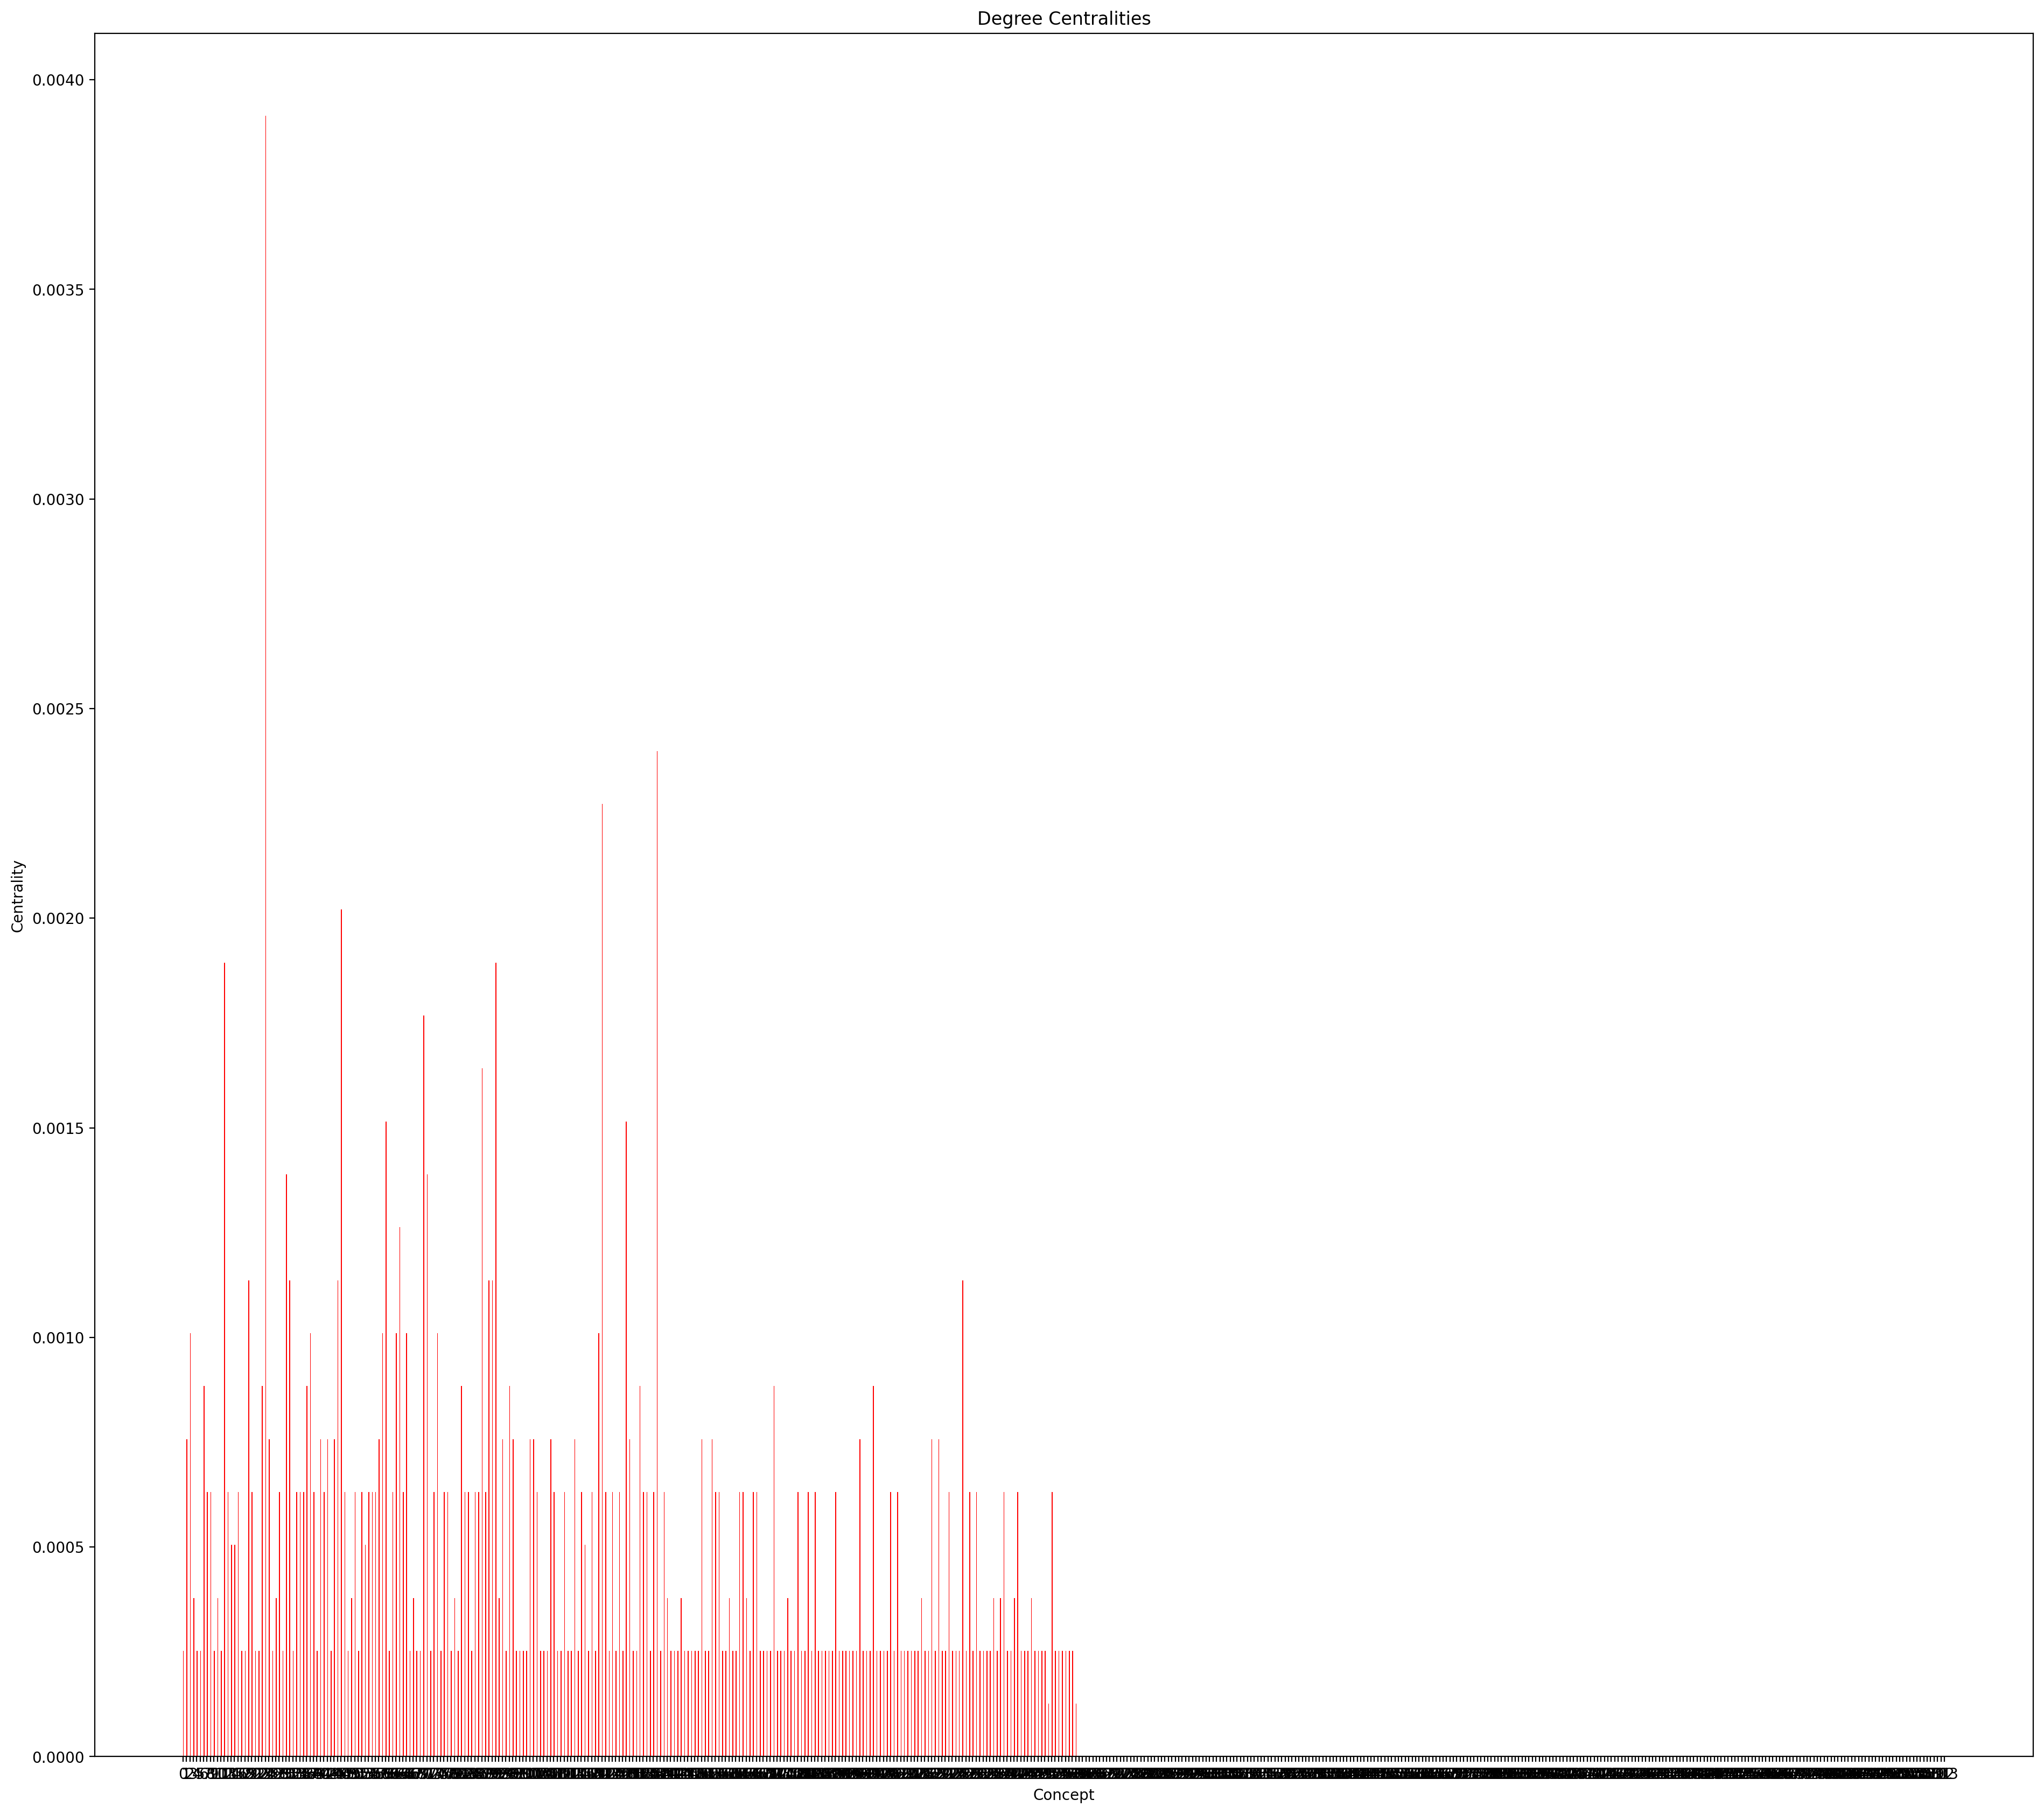

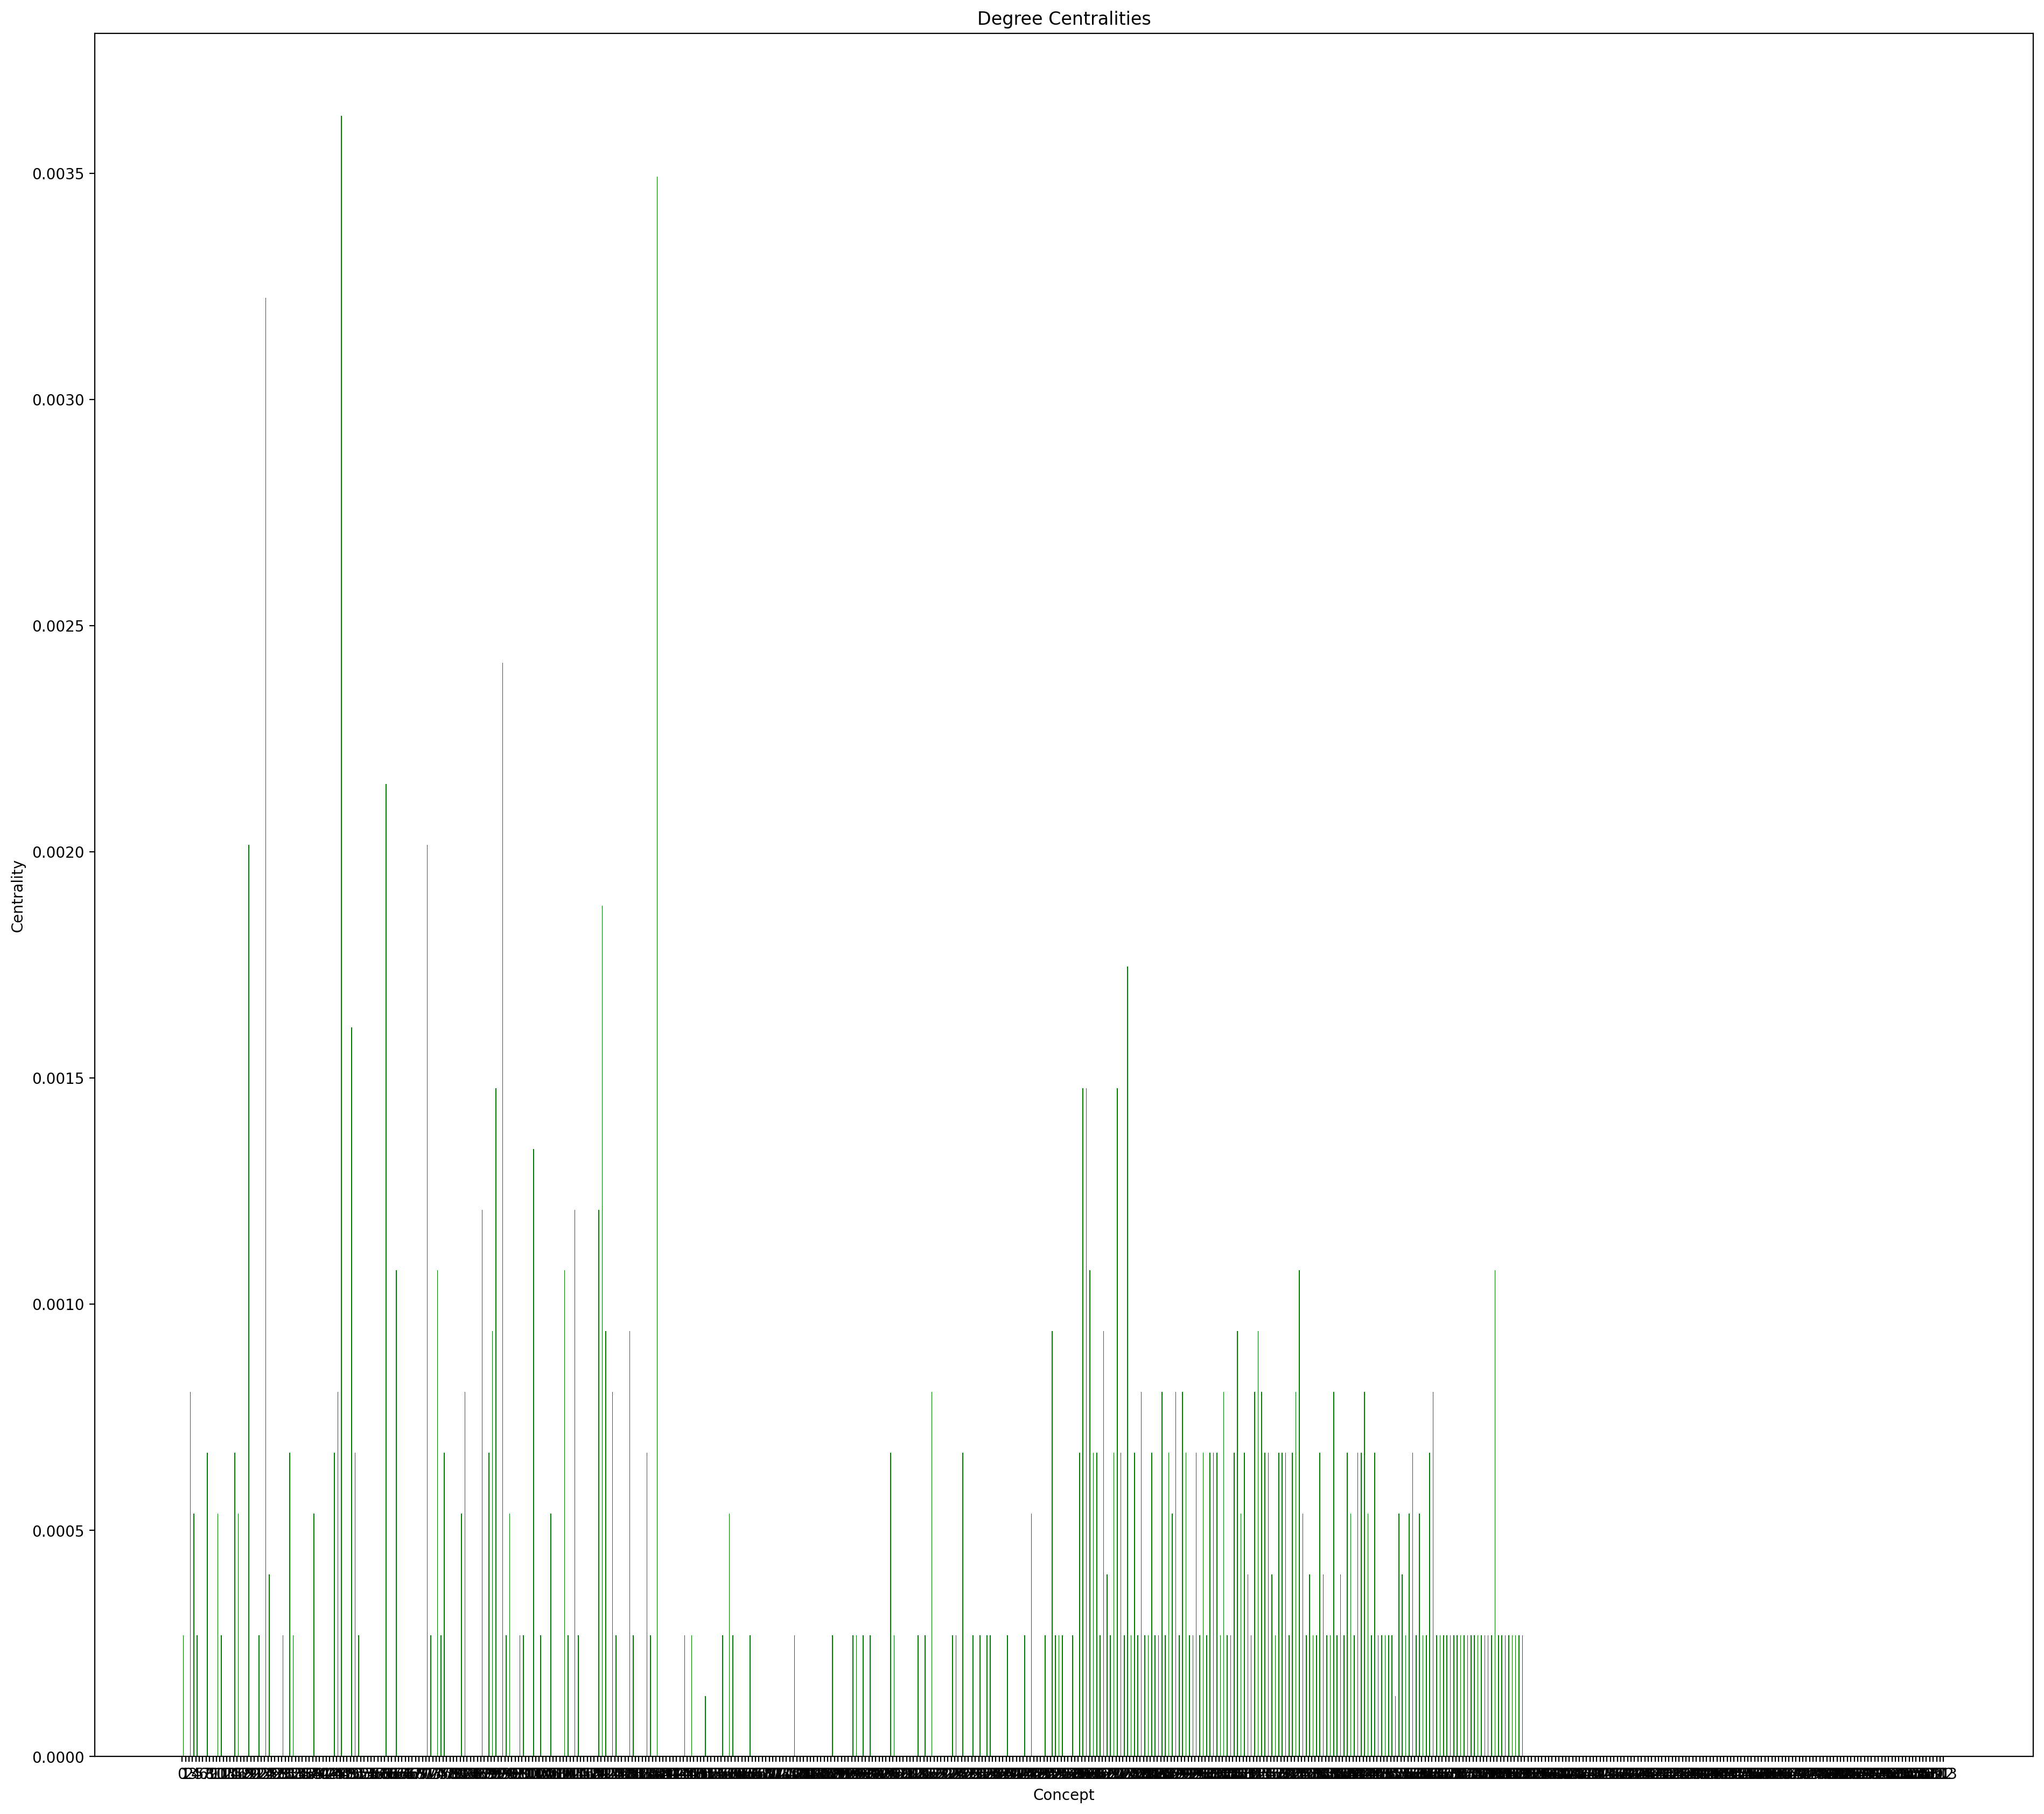

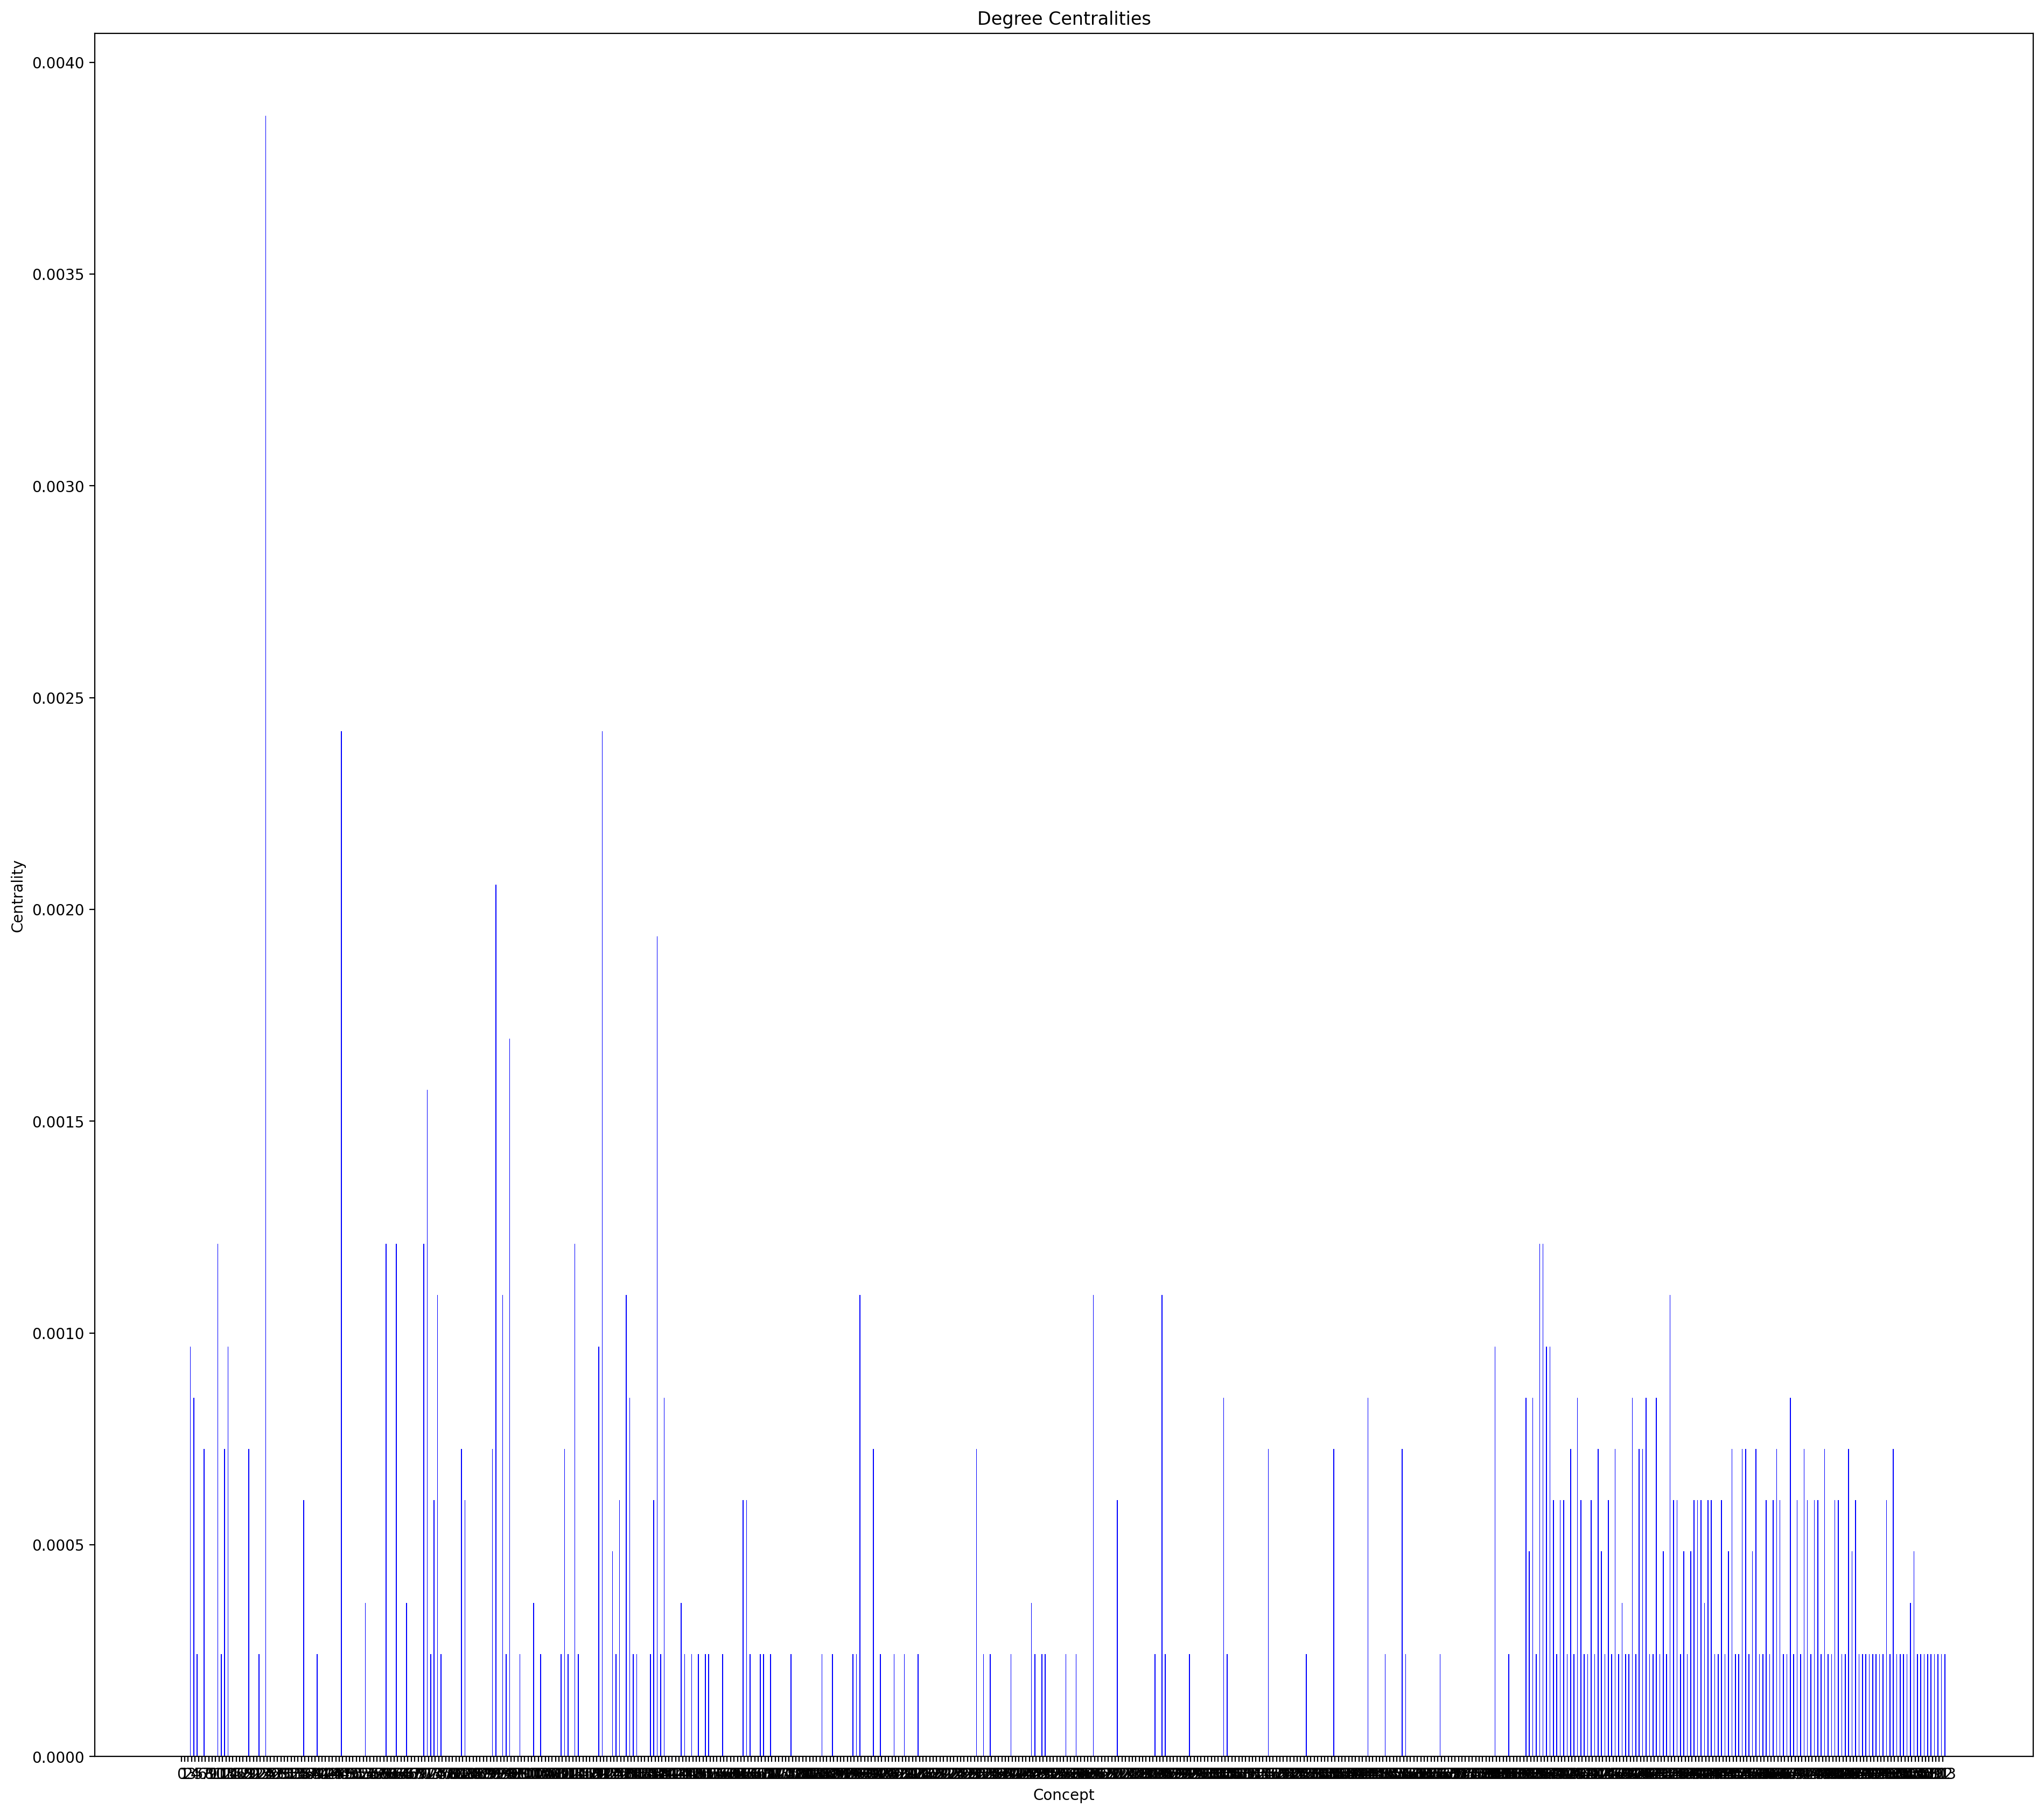

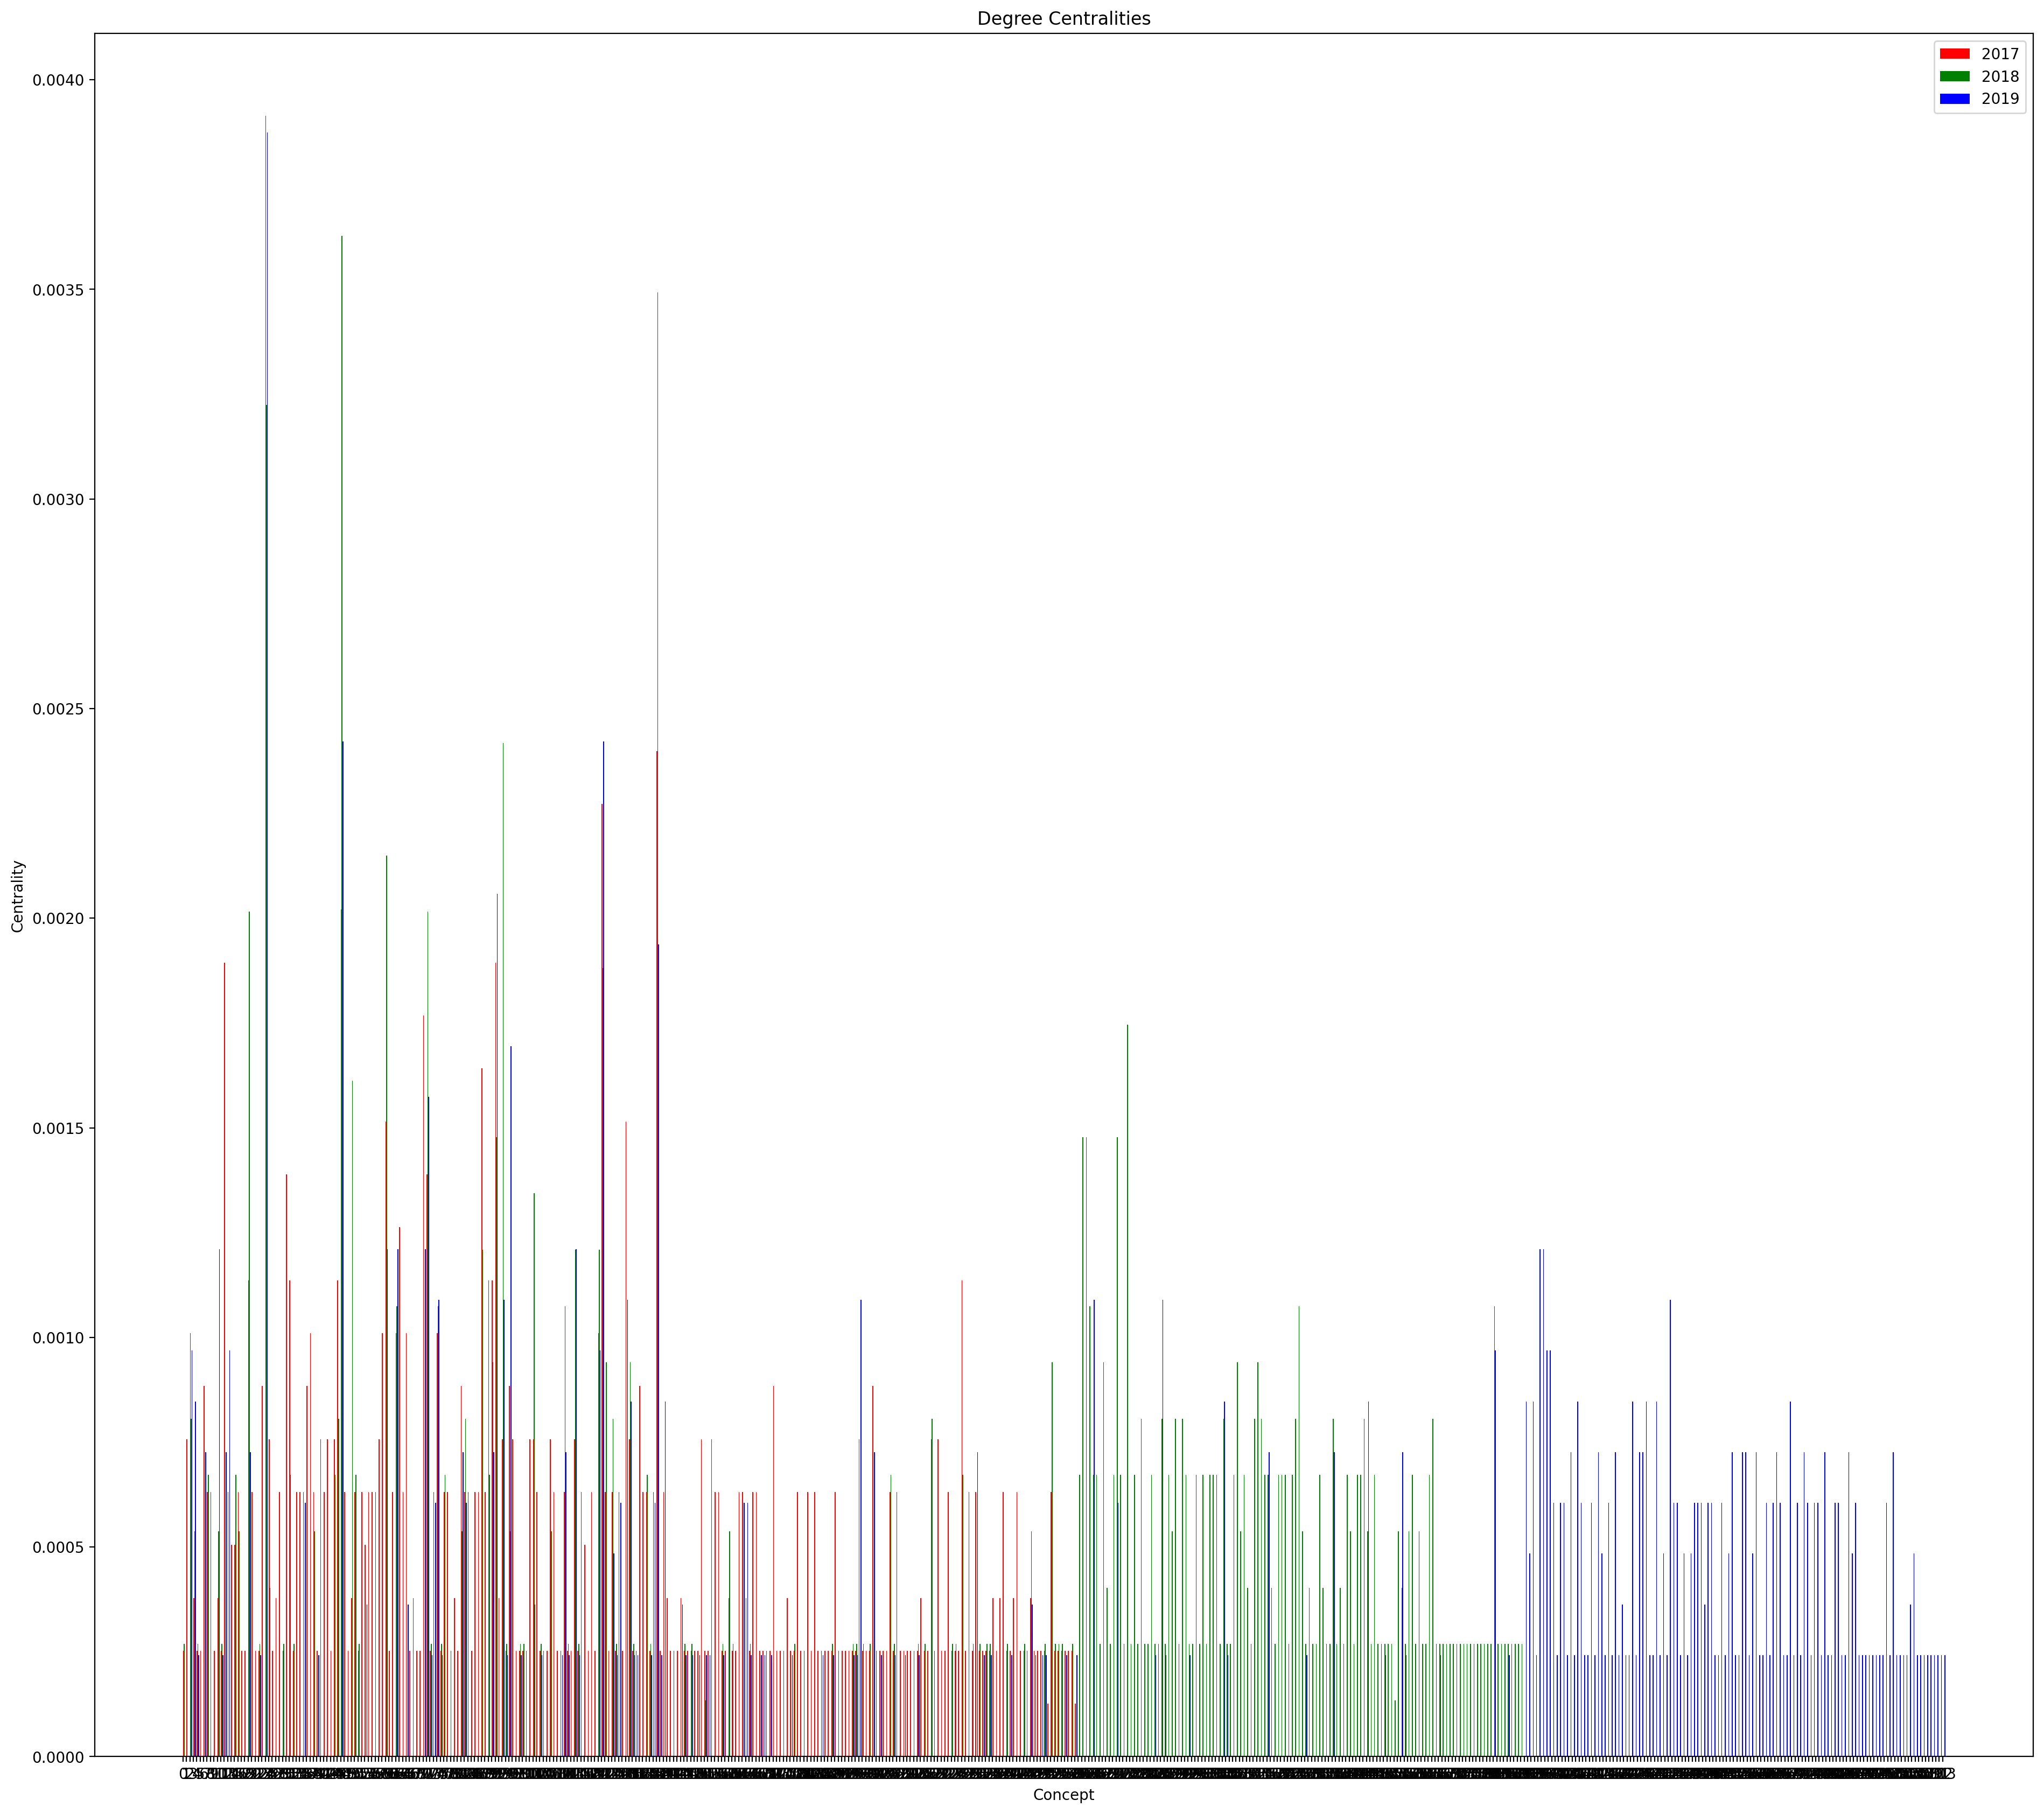

In [6]:
print('DEGREE CENTRALITY')
plot_all(deg_centrality, 'Degree Centralities')

TOP DEGREE CENTRALITIES
39
{rdflib.term.URIRef('http://local/local.owl#ontology'): [0.003914141414141414, 0.0032240730789897904, 0.00387409200968523], rdflib.term.URIRef('http://local/local.owl#sparql'): [0.002398989898989899, 0.003492745835572273, 0.001937046004842615], rdflib.term.URIRef('http://local/local.owl#ontologies'): [0.0022727272727272726, 0.0018807092960773778, 0.002421307506053269], rdflib.term.URIRef('http://local/local.owl#rdf'): [0.00202020202020202, 0.0036270822138635144, 0.002421307506053269], rdflib.term.URIRef('http://local/local.owl#semantics'): [0.001893939393939394, 0.0014777001612036541, 0.0020581113801452786], rdflib.term.URIRef('http://local/local.owl#description_logic'): [0.001893939393939394, 0, 0.0007263922518159806], rdflib.term.URIRef('http://local/local.owl#reasoning'): [0.0017676767676767678, 0, 0.0012106537530266344], rdflib.term.URIRef('http://local/local.owl#owl'): [0.0016414141414141414, 0.0012090274046211715, 0], rdflib.term.URIRef('http://local/lo

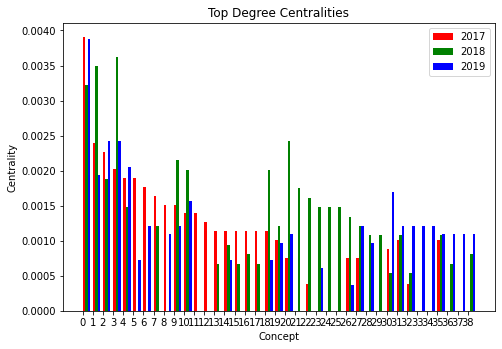

In [7]:
print('TOP DEGREE CENTRALITIES')
print(len(top_deg_centrality))
print(top_deg_centrality)
plot_combined(top_deg_centrality, 'Top Degree Centralities')

DEGREE CENTRALITY GRAPH EXAMPLES
Subgraph for immediate neighbors of http://local/local.owl#ontology, in 2017:
- # of immediate neighbors: 31


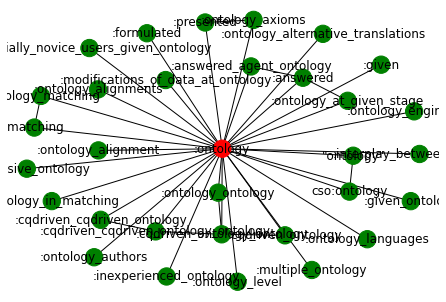

Subgraph for immediate neighbors of http://local/local.owl#ontology, in 2018:
- # of immediate neighbors: 22


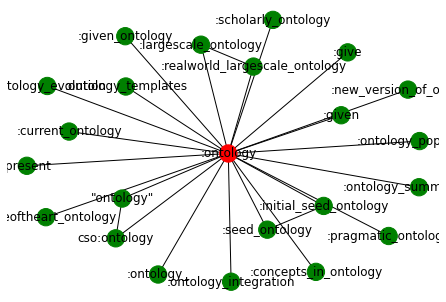

Subgraph for immediate neighbors of http://local/local.owl#ontology, in 2019:
- # of immediate neighbors: 32


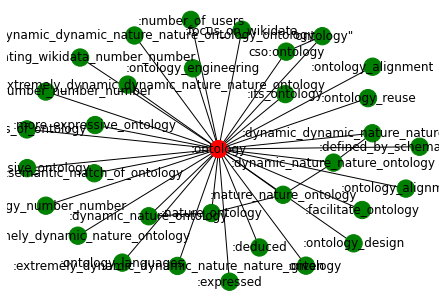

In [8]:
print('DEGREE CENTRALITY GRAPH EXAMPLES')
for curr_year in nxgs.keys():
    for key in top_deg_centrality.keys():
        if 'ontology' in key:
            draw_subgraph(curr_year, key)
            break

In [9]:
eig_centrality, top_eig_centrality = get_centrality(nx.eigenvector_centrality)

Top 20 values for 2017
 - http://local/local.owl#rdf_data: 0.02755650190212148 -- ref: https://cso.kmi.open.ac.uk/topics/rdf_data
 - http://local/local.owl#data_mining: 0.026702616669402733 -- ref: https://cso.kmi.open.ac.uk/topics/data_mining
 - http://local/local.owl#linked_data: 0.025226677095369198 -- ref: https://cso.kmi.open.ac.uk/topics/linked_data
 - http://local/local.owl#machine_translation: 0.015052244965256591 -- ref: https://cso.kmi.open.ac.uk/topics/machine_translation
 - http://local/local.owl#machine_learning: 0.012801461666158366 -- ref: https://cso.kmi.open.ac.uk/topics/machine_learning
 - http://local/local.owl#deep_learning: 0.011351896107028251 -- ref: https://cso.kmi.open.ac.uk/topics/deep_learning
 - http://local/local.owl#servers: 0.010496740094754016 -- ref: https://cso.kmi.open.ac.uk/topics/servers
 - http://local/local.owl#query_results: 0.010258167825619717 -- ref: https://cso.kmi.open.ac.uk/topics/query_results
 - http://local/local.owl#ontologies: 0.009773

ALL EIGENVECTOR CENTRALITIES


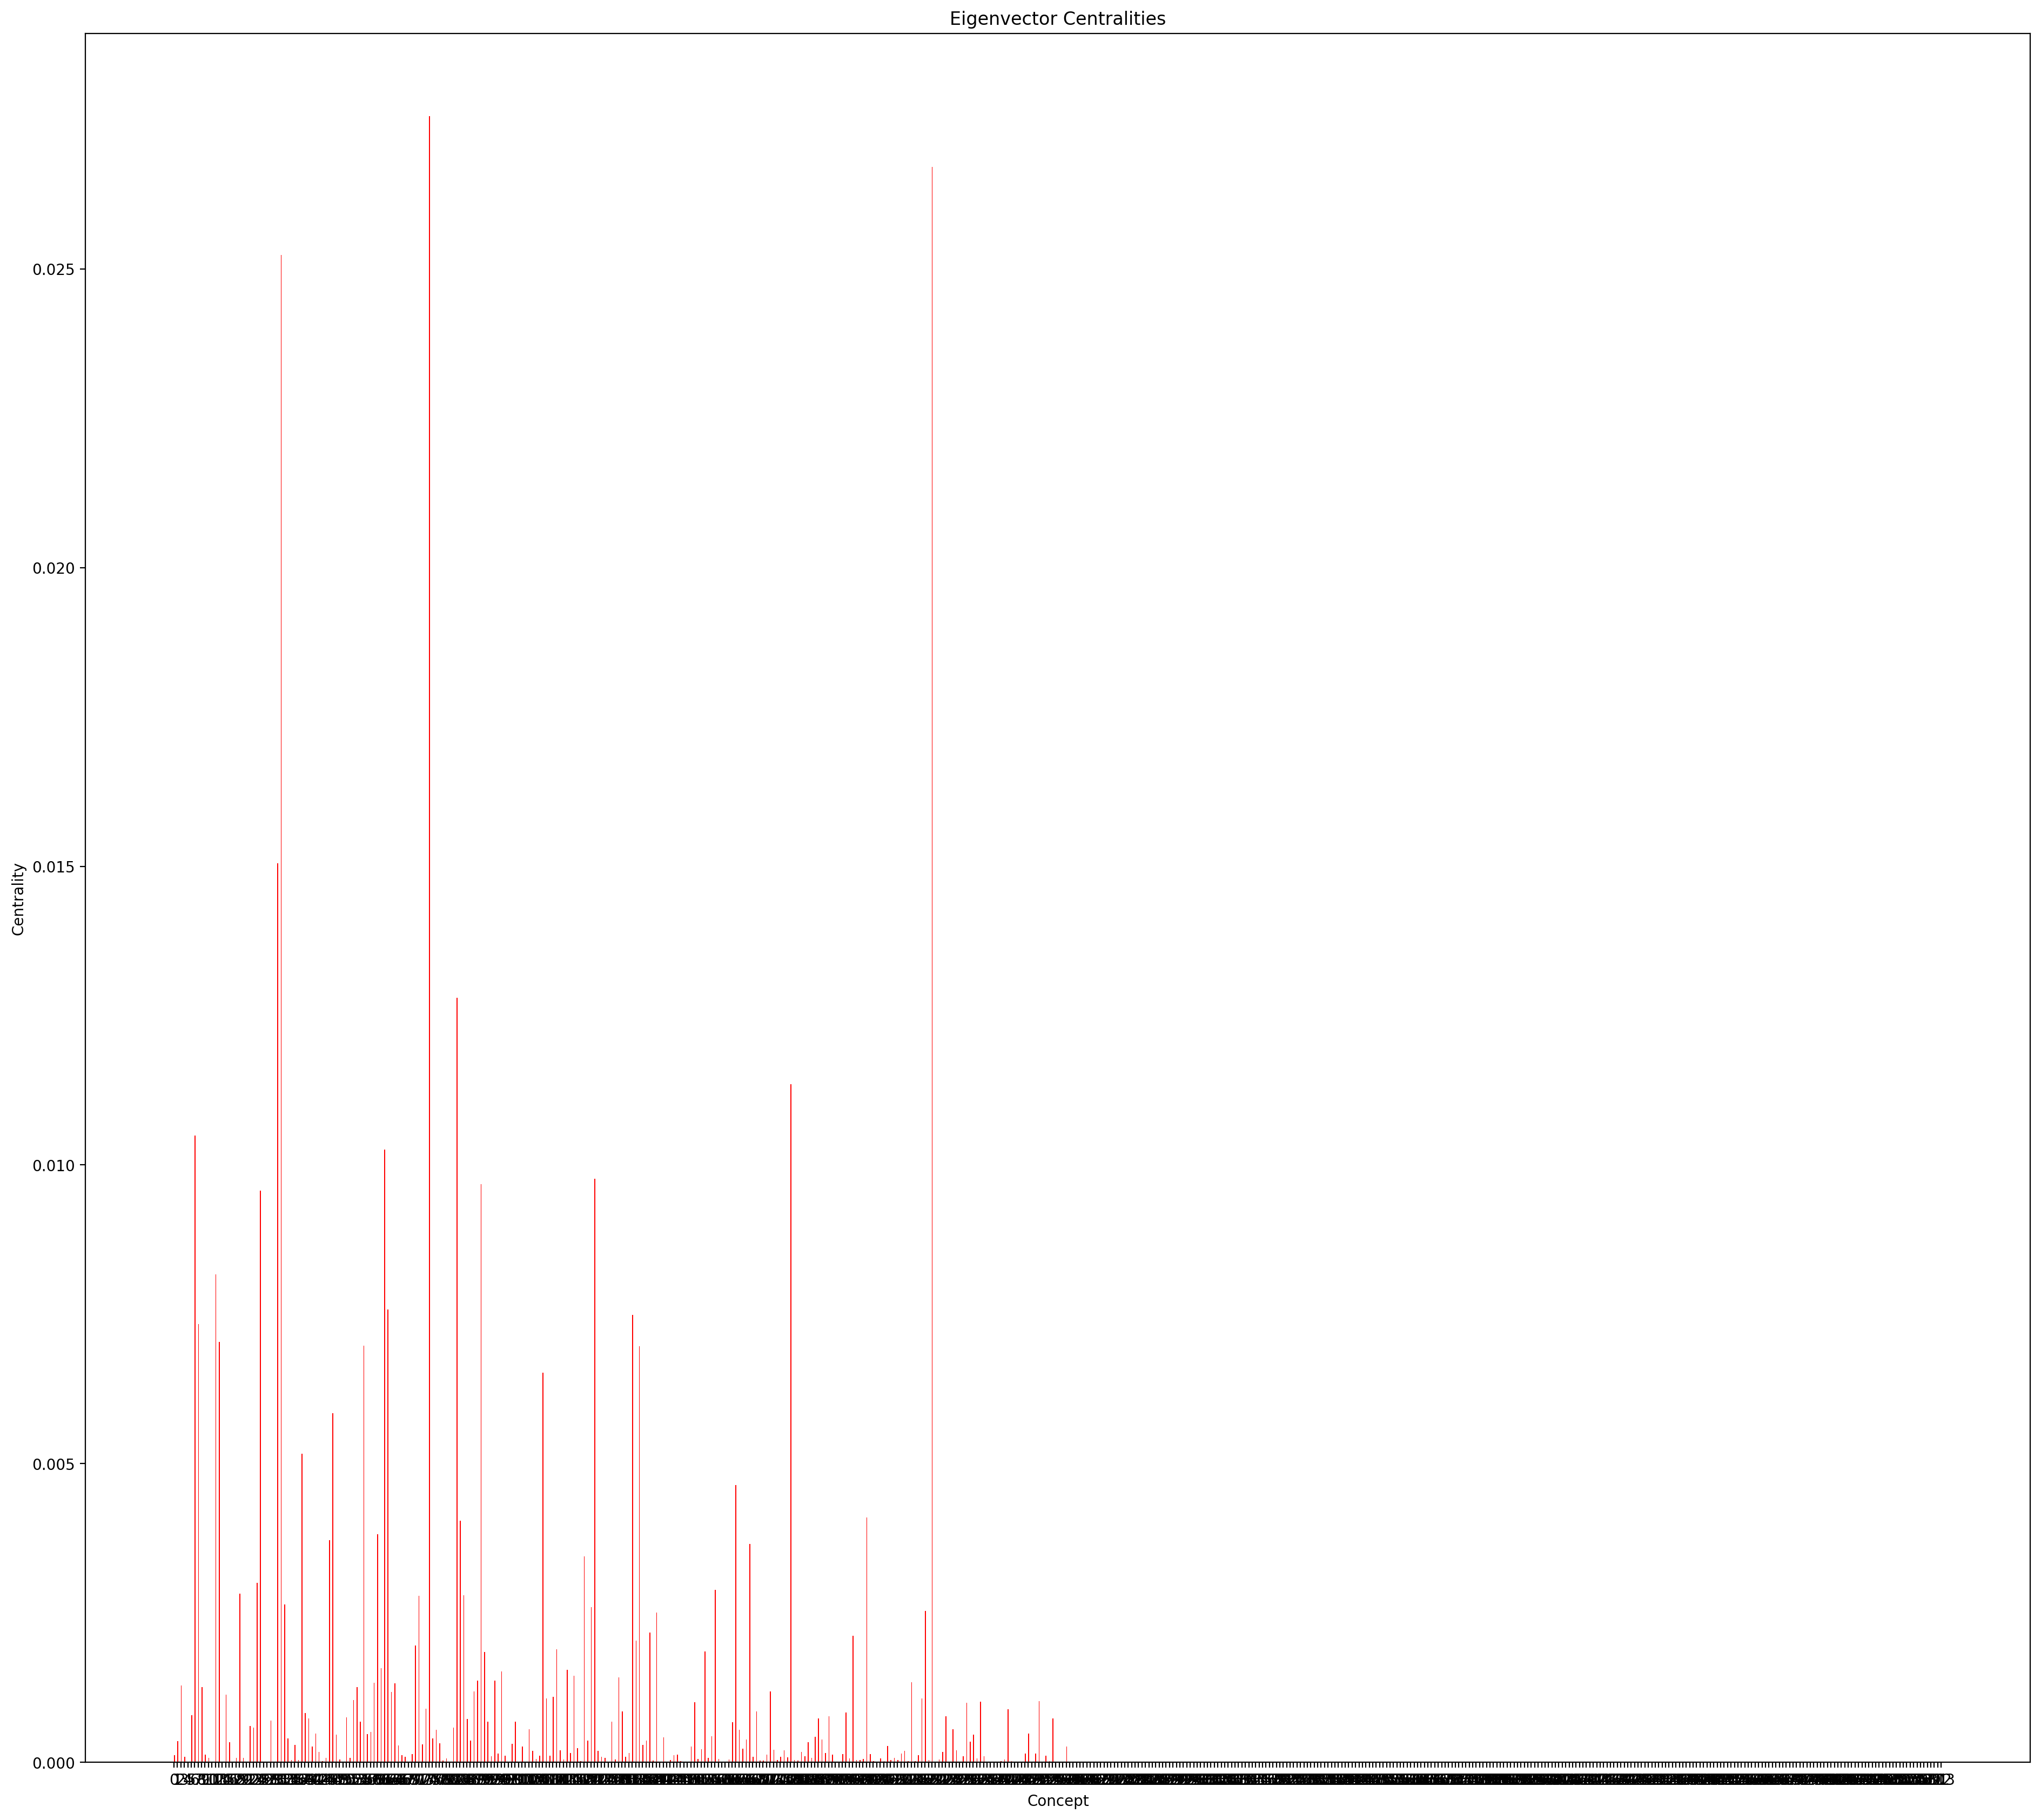

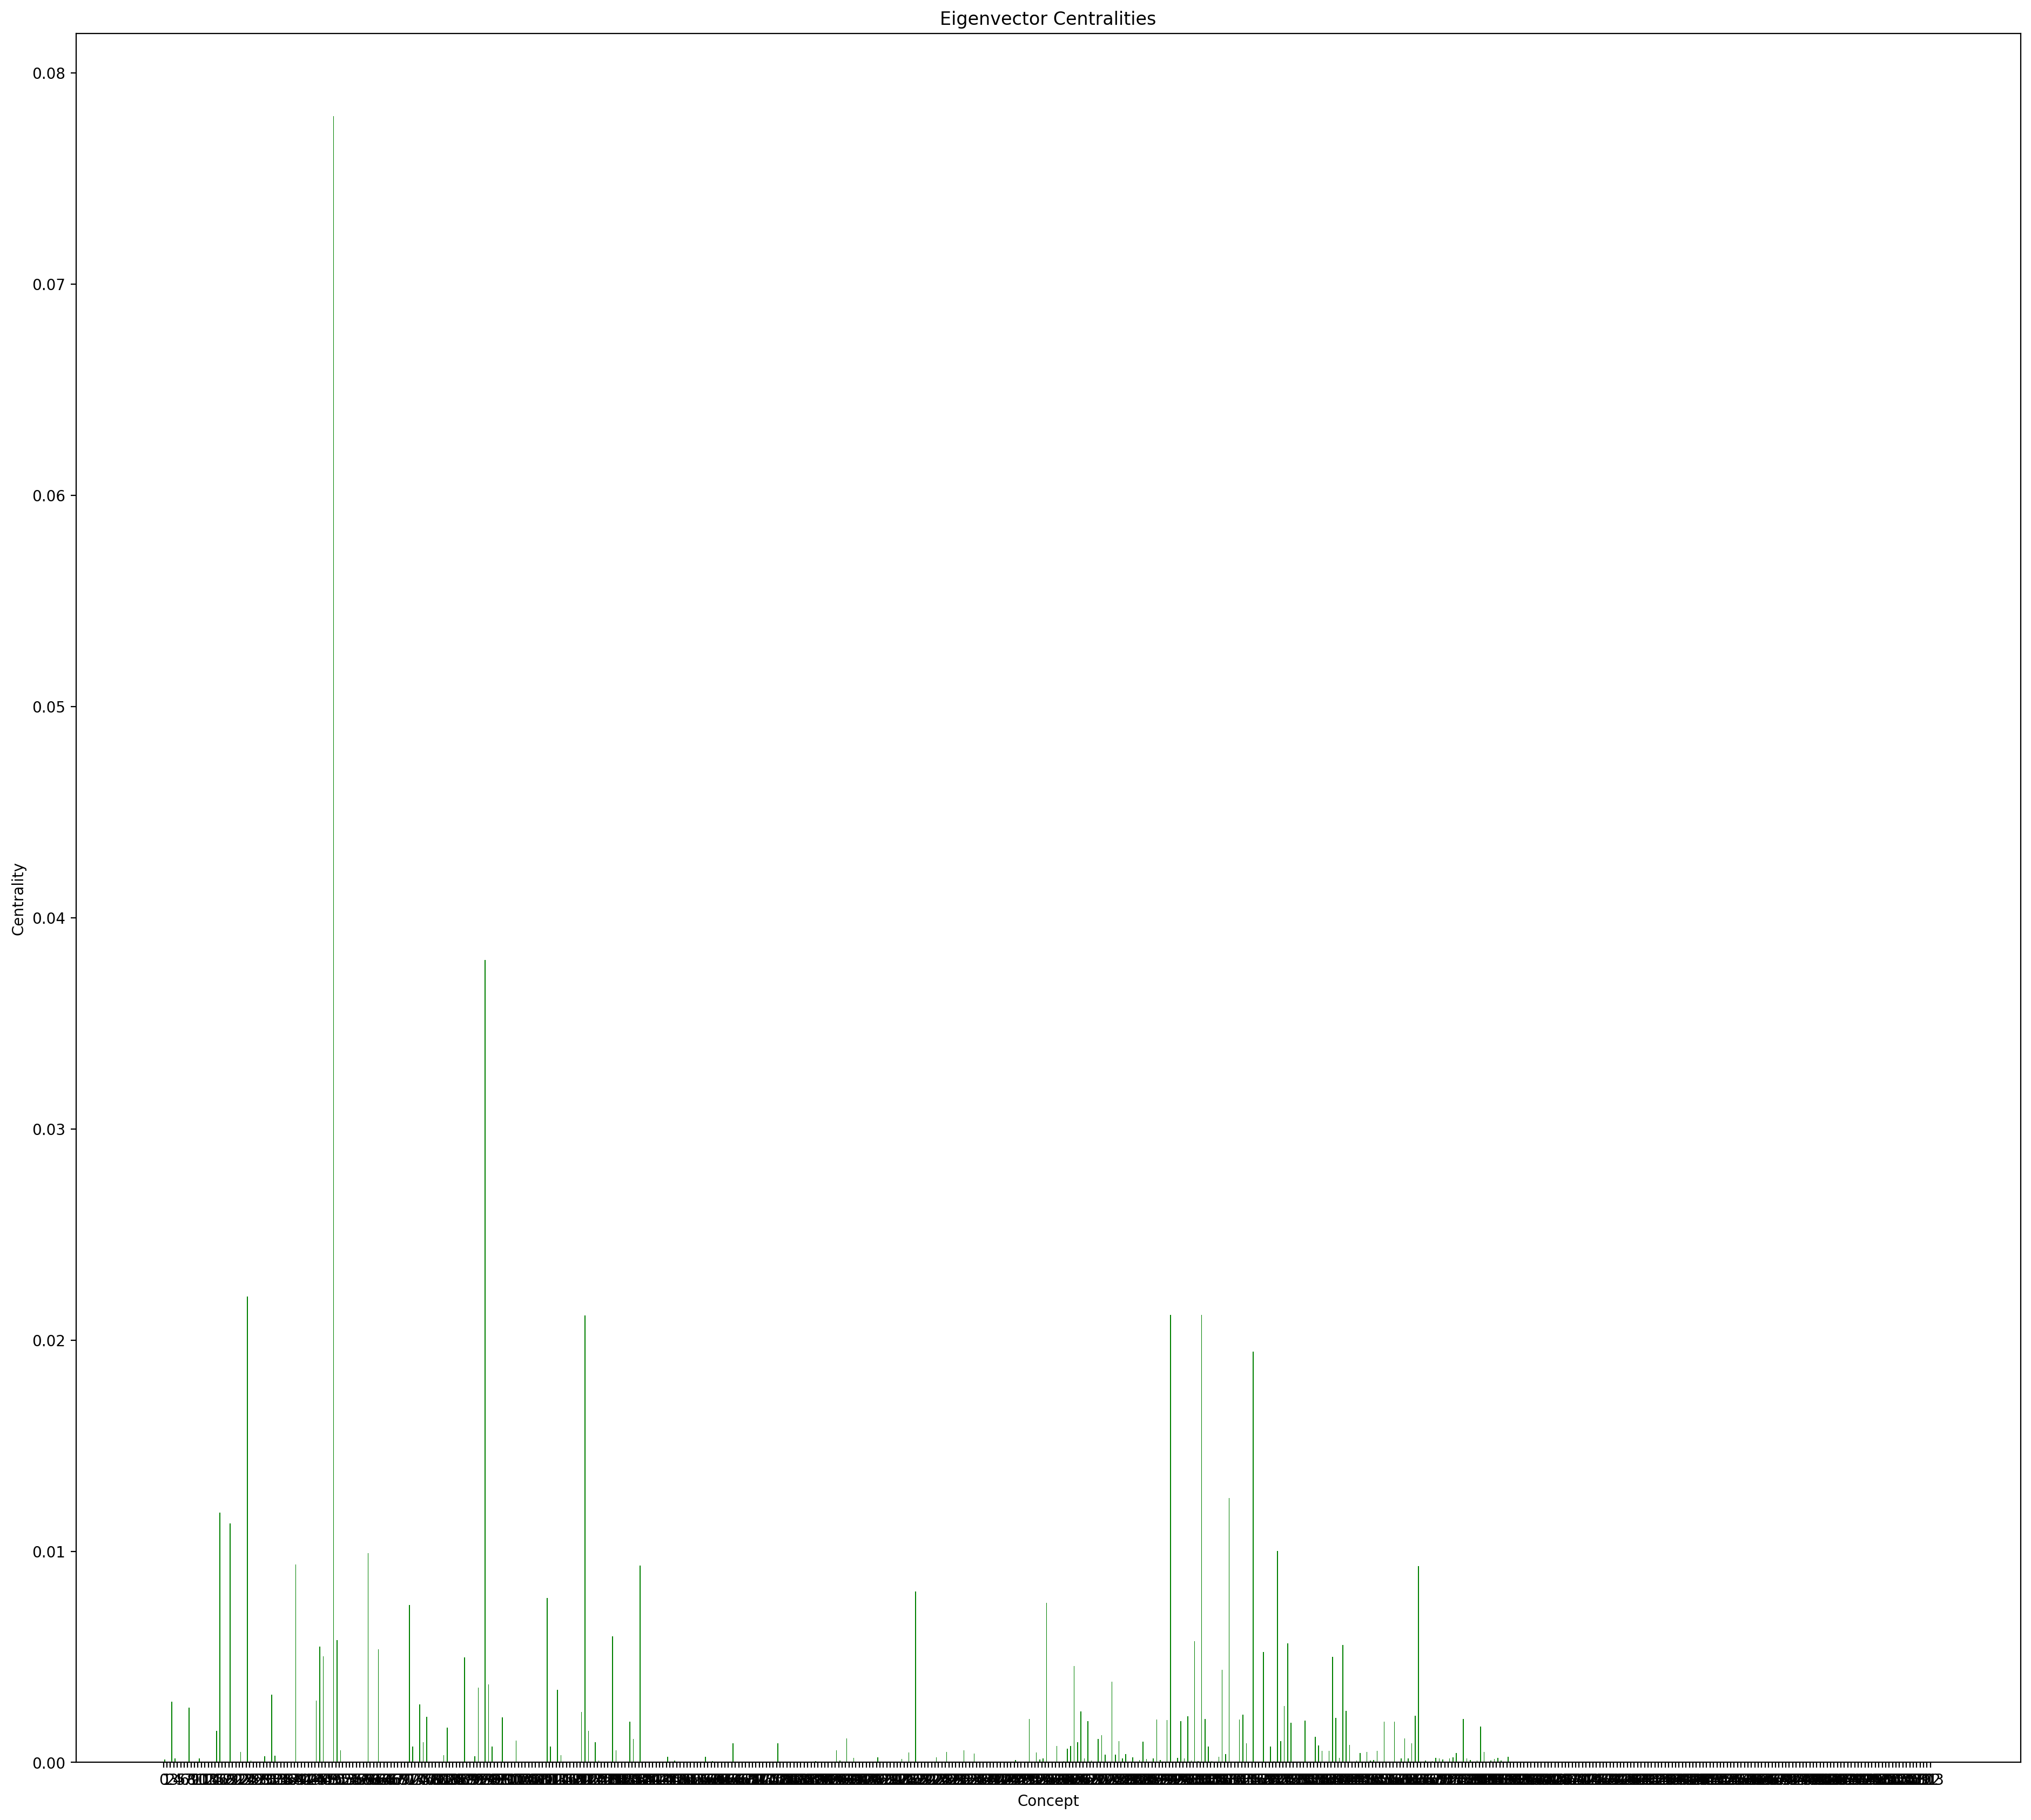

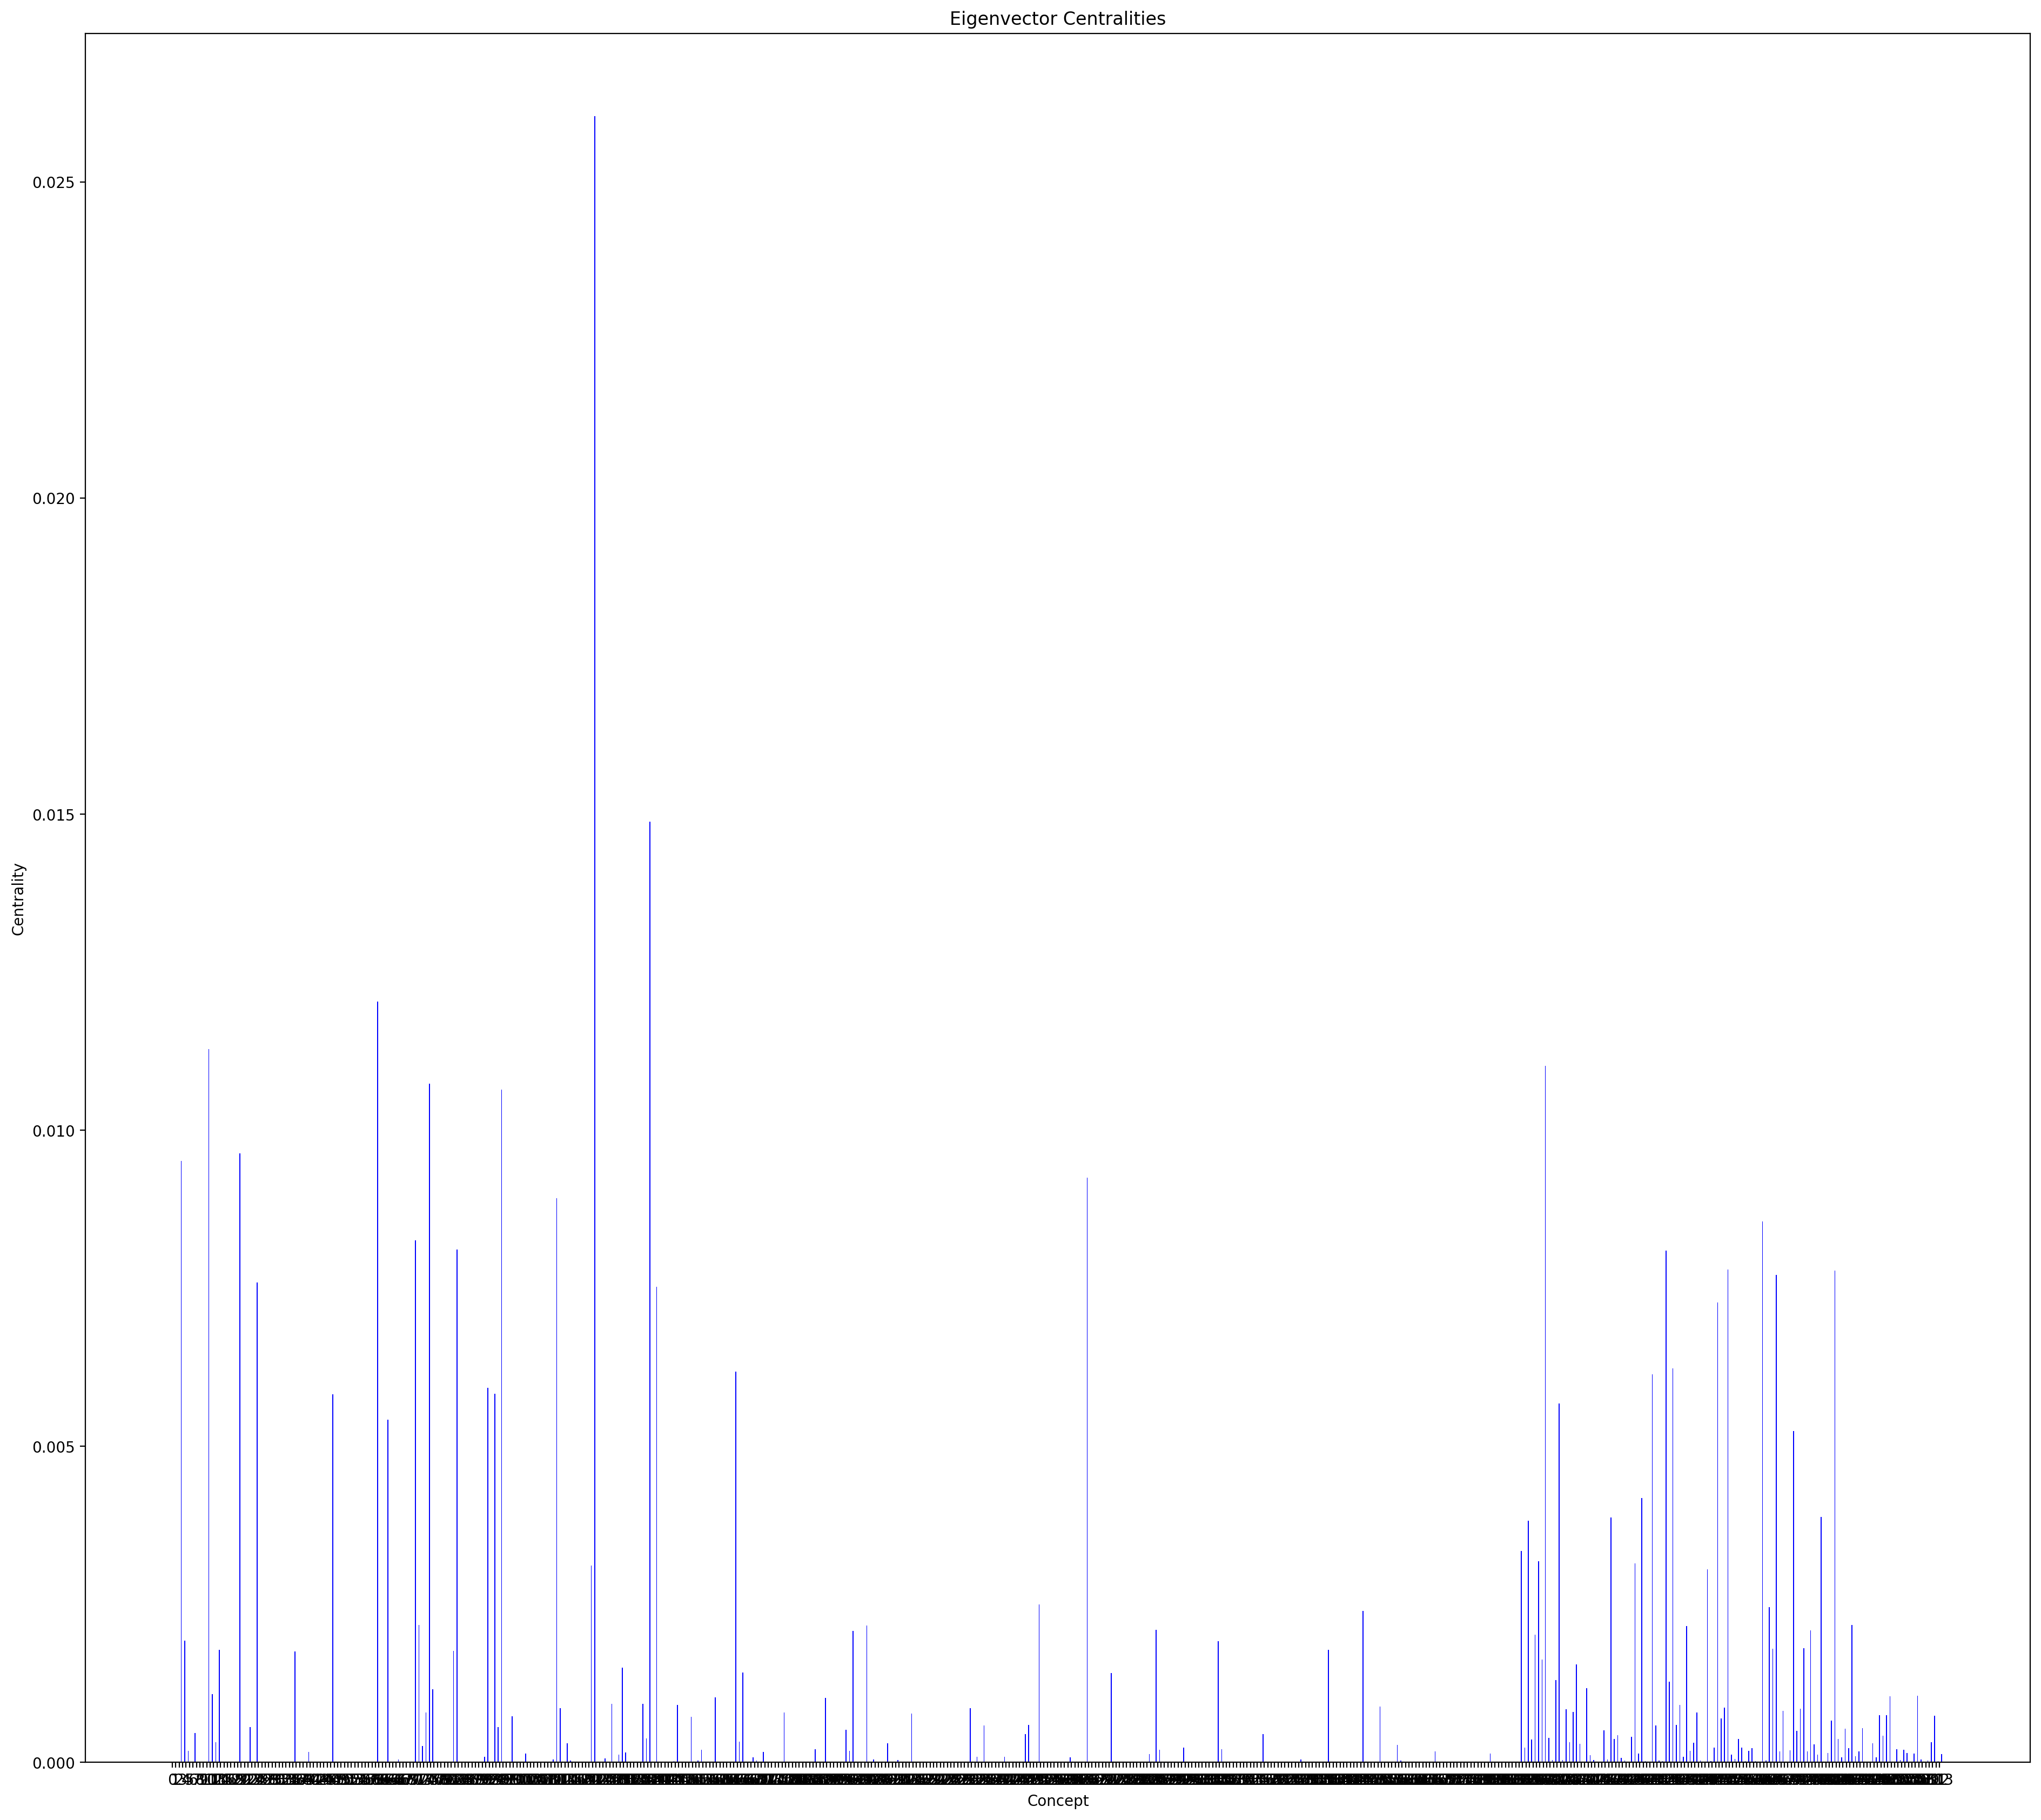

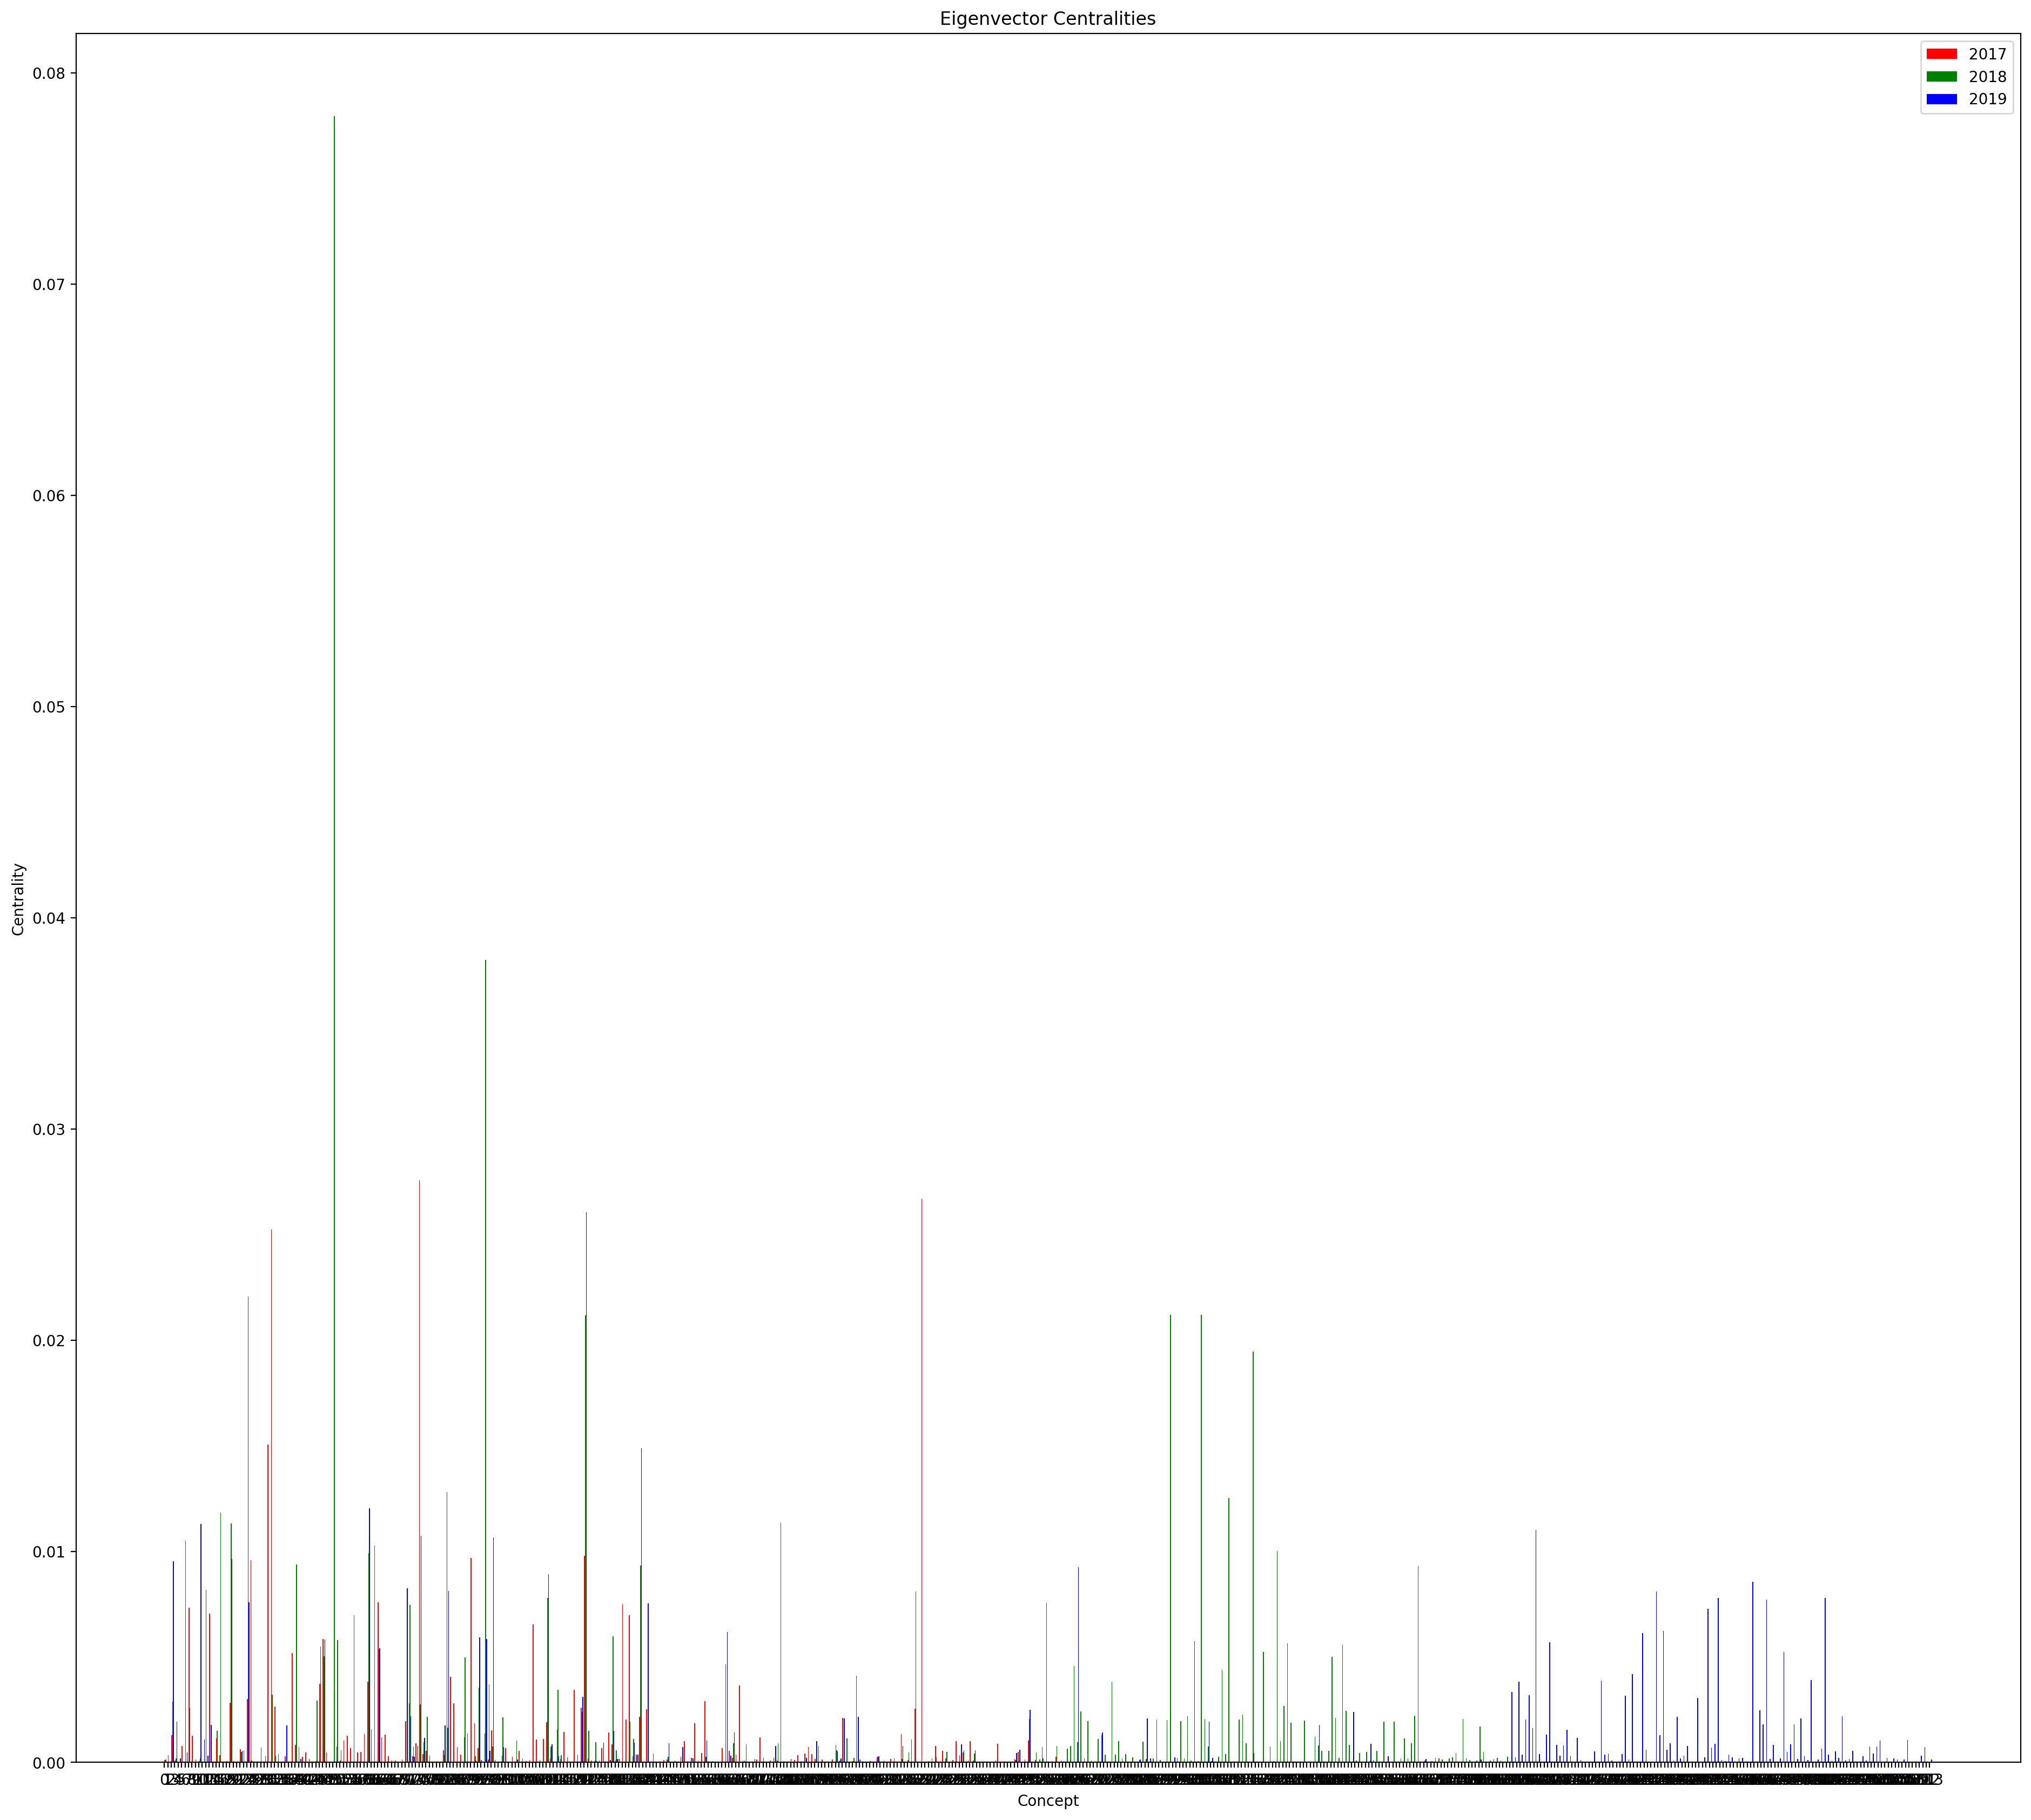

In [10]:
print('ALL EIGENVECTOR CENTRALITIES')
plot_all(eig_centrality, 'Eigenvector Centralities')

TOP EIGENVECTOR CENTRALITIES
51
{rdflib.term.URIRef('http://local/local.owl#rdf_data'): [0.02755650190212148, 0.0027433223509468955, 0.010735144291855575], rdflib.term.URIRef('http://local/local.owl#data_mining'): [0.026702616669402733, 0, 0], rdflib.term.URIRef('http://local/local.owl#linked_data'): [0.025226677095369198, 0.0032125133208457694, 0], rdflib.term.URIRef('http://local/local.owl#machine_translation'): [0.015052244965256591, 0, 0], rdflib.term.URIRef('http://local/local.owl#machine_learning'): [0.012801461666158366, 0.0016532129574826629, 0.00811172526052163], rdflib.term.URIRef('http://local/local.owl#deep_learning'): [0.011351896107028251, 0, 0], rdflib.term.URIRef('http://local/local.owl#servers'): [0.010496740094754016, 0, 0.00046498312383354246], rdflib.term.URIRef('http://local/local.owl#query_results'): [0.010258167825619717, 0, 0], rdflib.term.URIRef('http://local/local.owl#ontologies'): [0.00977380765781098, 0.02117173306432249, 0.02604572123294355], rdflib.term.UR

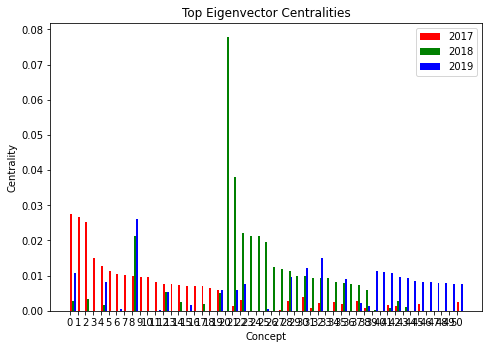

In [11]:
print('TOP EIGENVECTOR CENTRALITIES')
print(len(top_eig_centrality))
print(top_eig_centrality)
plot_combined(top_eig_centrality, 'Top Eigenvector Centralities')

EIGENVECTOR CENTRALITY GRAPH EXAMPLES
Subgraph for level 2 neighbors of http://local/local.owl#ontology, in 2017:


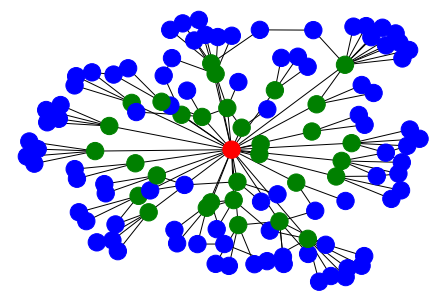

Subgraph for level 2 neighbors of http://local/local.owl#ontology, in 2018:


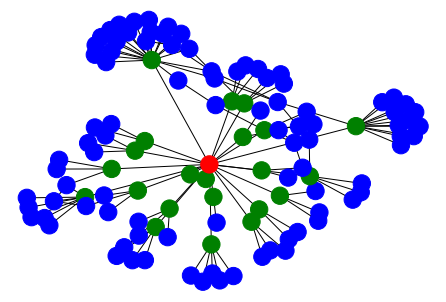

Subgraph for level 2 neighbors of http://local/local.owl#ontology, in 2019:


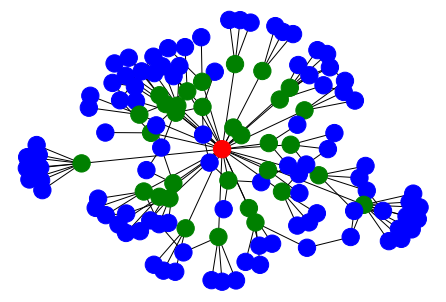

In [12]:
print('EIGENVECTOR CENTRALITY GRAPH EXAMPLES')
for curr_year in nxgs.keys():
    for key in top_eig_centrality.keys():
        if 'ontology' in key:
            draw_subgraph(curr_year, key, neighborhood_level=2)
            break

In [13]:
bet_centrality, top_bet_centrality = get_centrality(nx.betweenness_centrality)

Top 20 values for 2017
 - http://local/local.owl#ontology: 0.025287971961764973 -- ref: https://cso.kmi.open.ac.uk/topics/ontology
 - http://local/local.owl#ontologies: 0.014802080404017516 -- ref: https://cso.kmi.open.ac.uk/topics/ontologies
 - http://local/local.owl#description_logic: 0.011670862738332592 -- ref: https://cso.kmi.open.ac.uk/topics/description_logic
 - http://local/local.owl#sparql: 0.011629415763141374 -- ref: https://cso.kmi.open.ac.uk/topics/sparql
 - http://local/local.owl#linked_data: 0.011601707079704647 -- ref: https://cso.kmi.open.ac.uk/topics/linked_data
 - http://local/local.owl#rdf: 0.011195367019267882 -- ref: https://cso.kmi.open.ac.uk/topics/rdf
 - http://local/local.owl#social_media: 0.01086557763228804 -- ref: https://cso.kmi.open.ac.uk/topics/social_media
 - http://local/local.owl#machine_translation: 0.009223579542774469 -- ref: https://cso.kmi.open.ac.uk/topics/machine_translation
 - http://local/local.owl#reasoning: 0.007978521747513278 -- ref: http

ALL BETWEENNESS CENTRALITIES


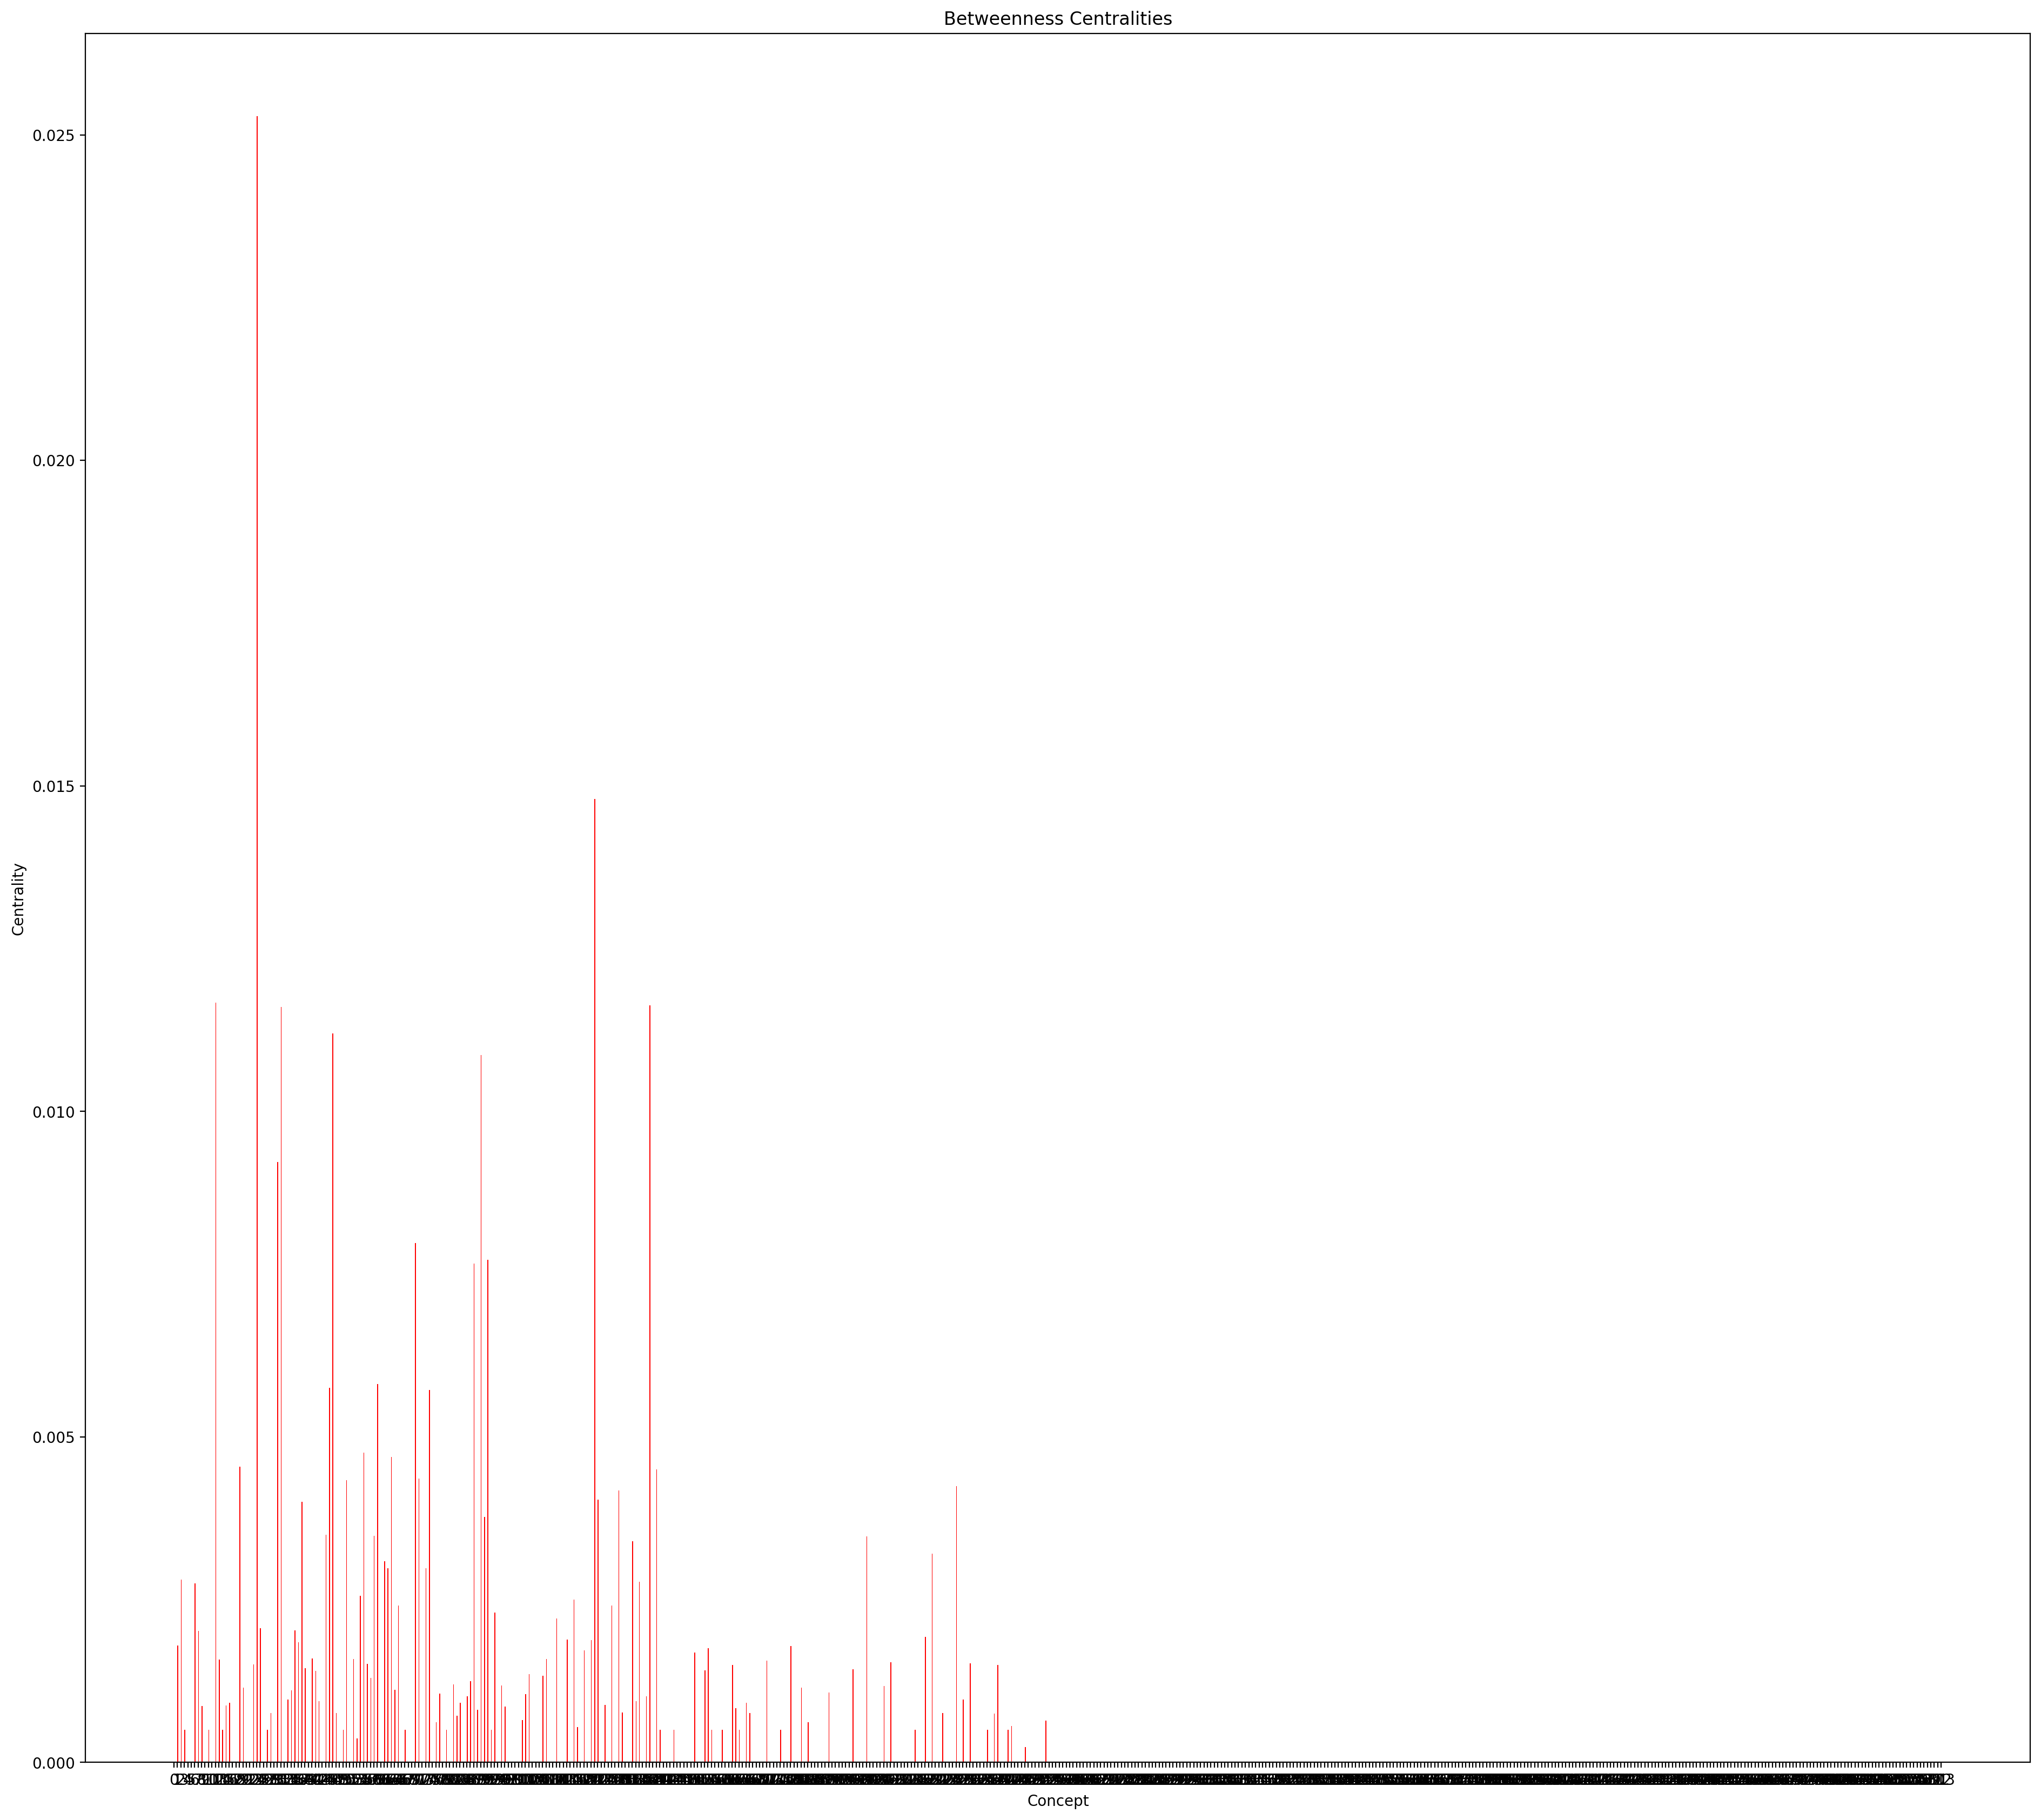

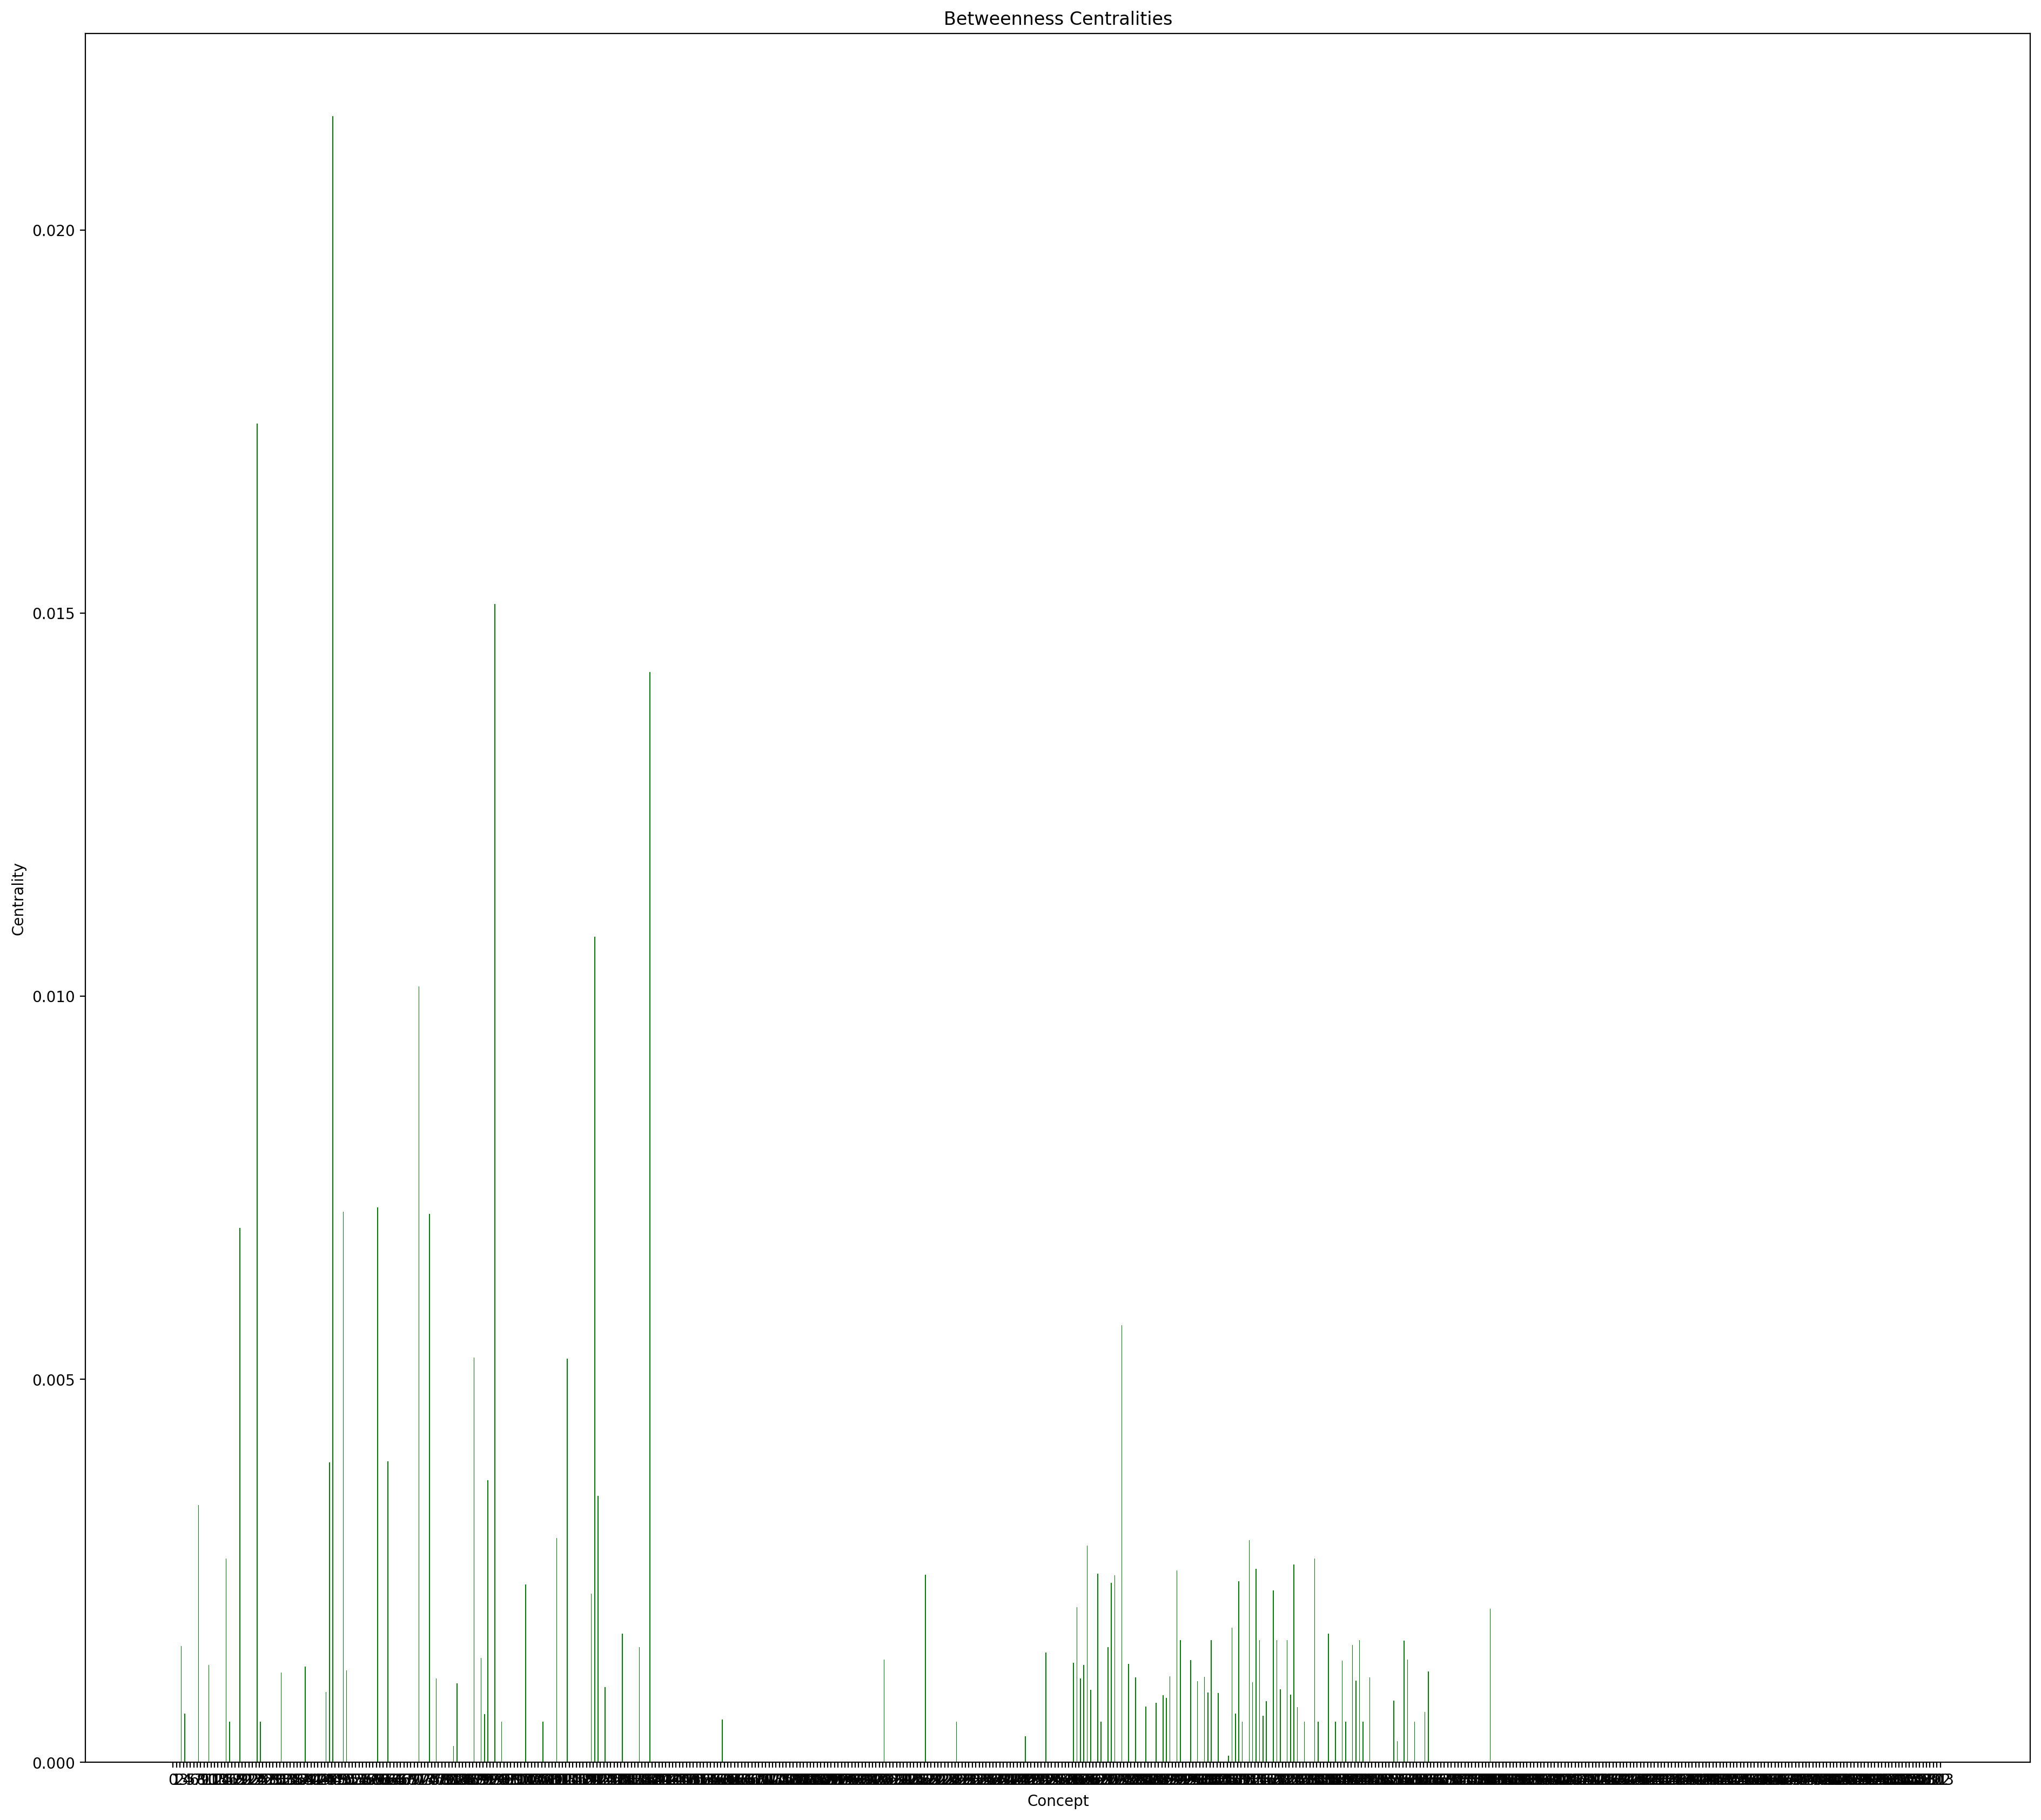

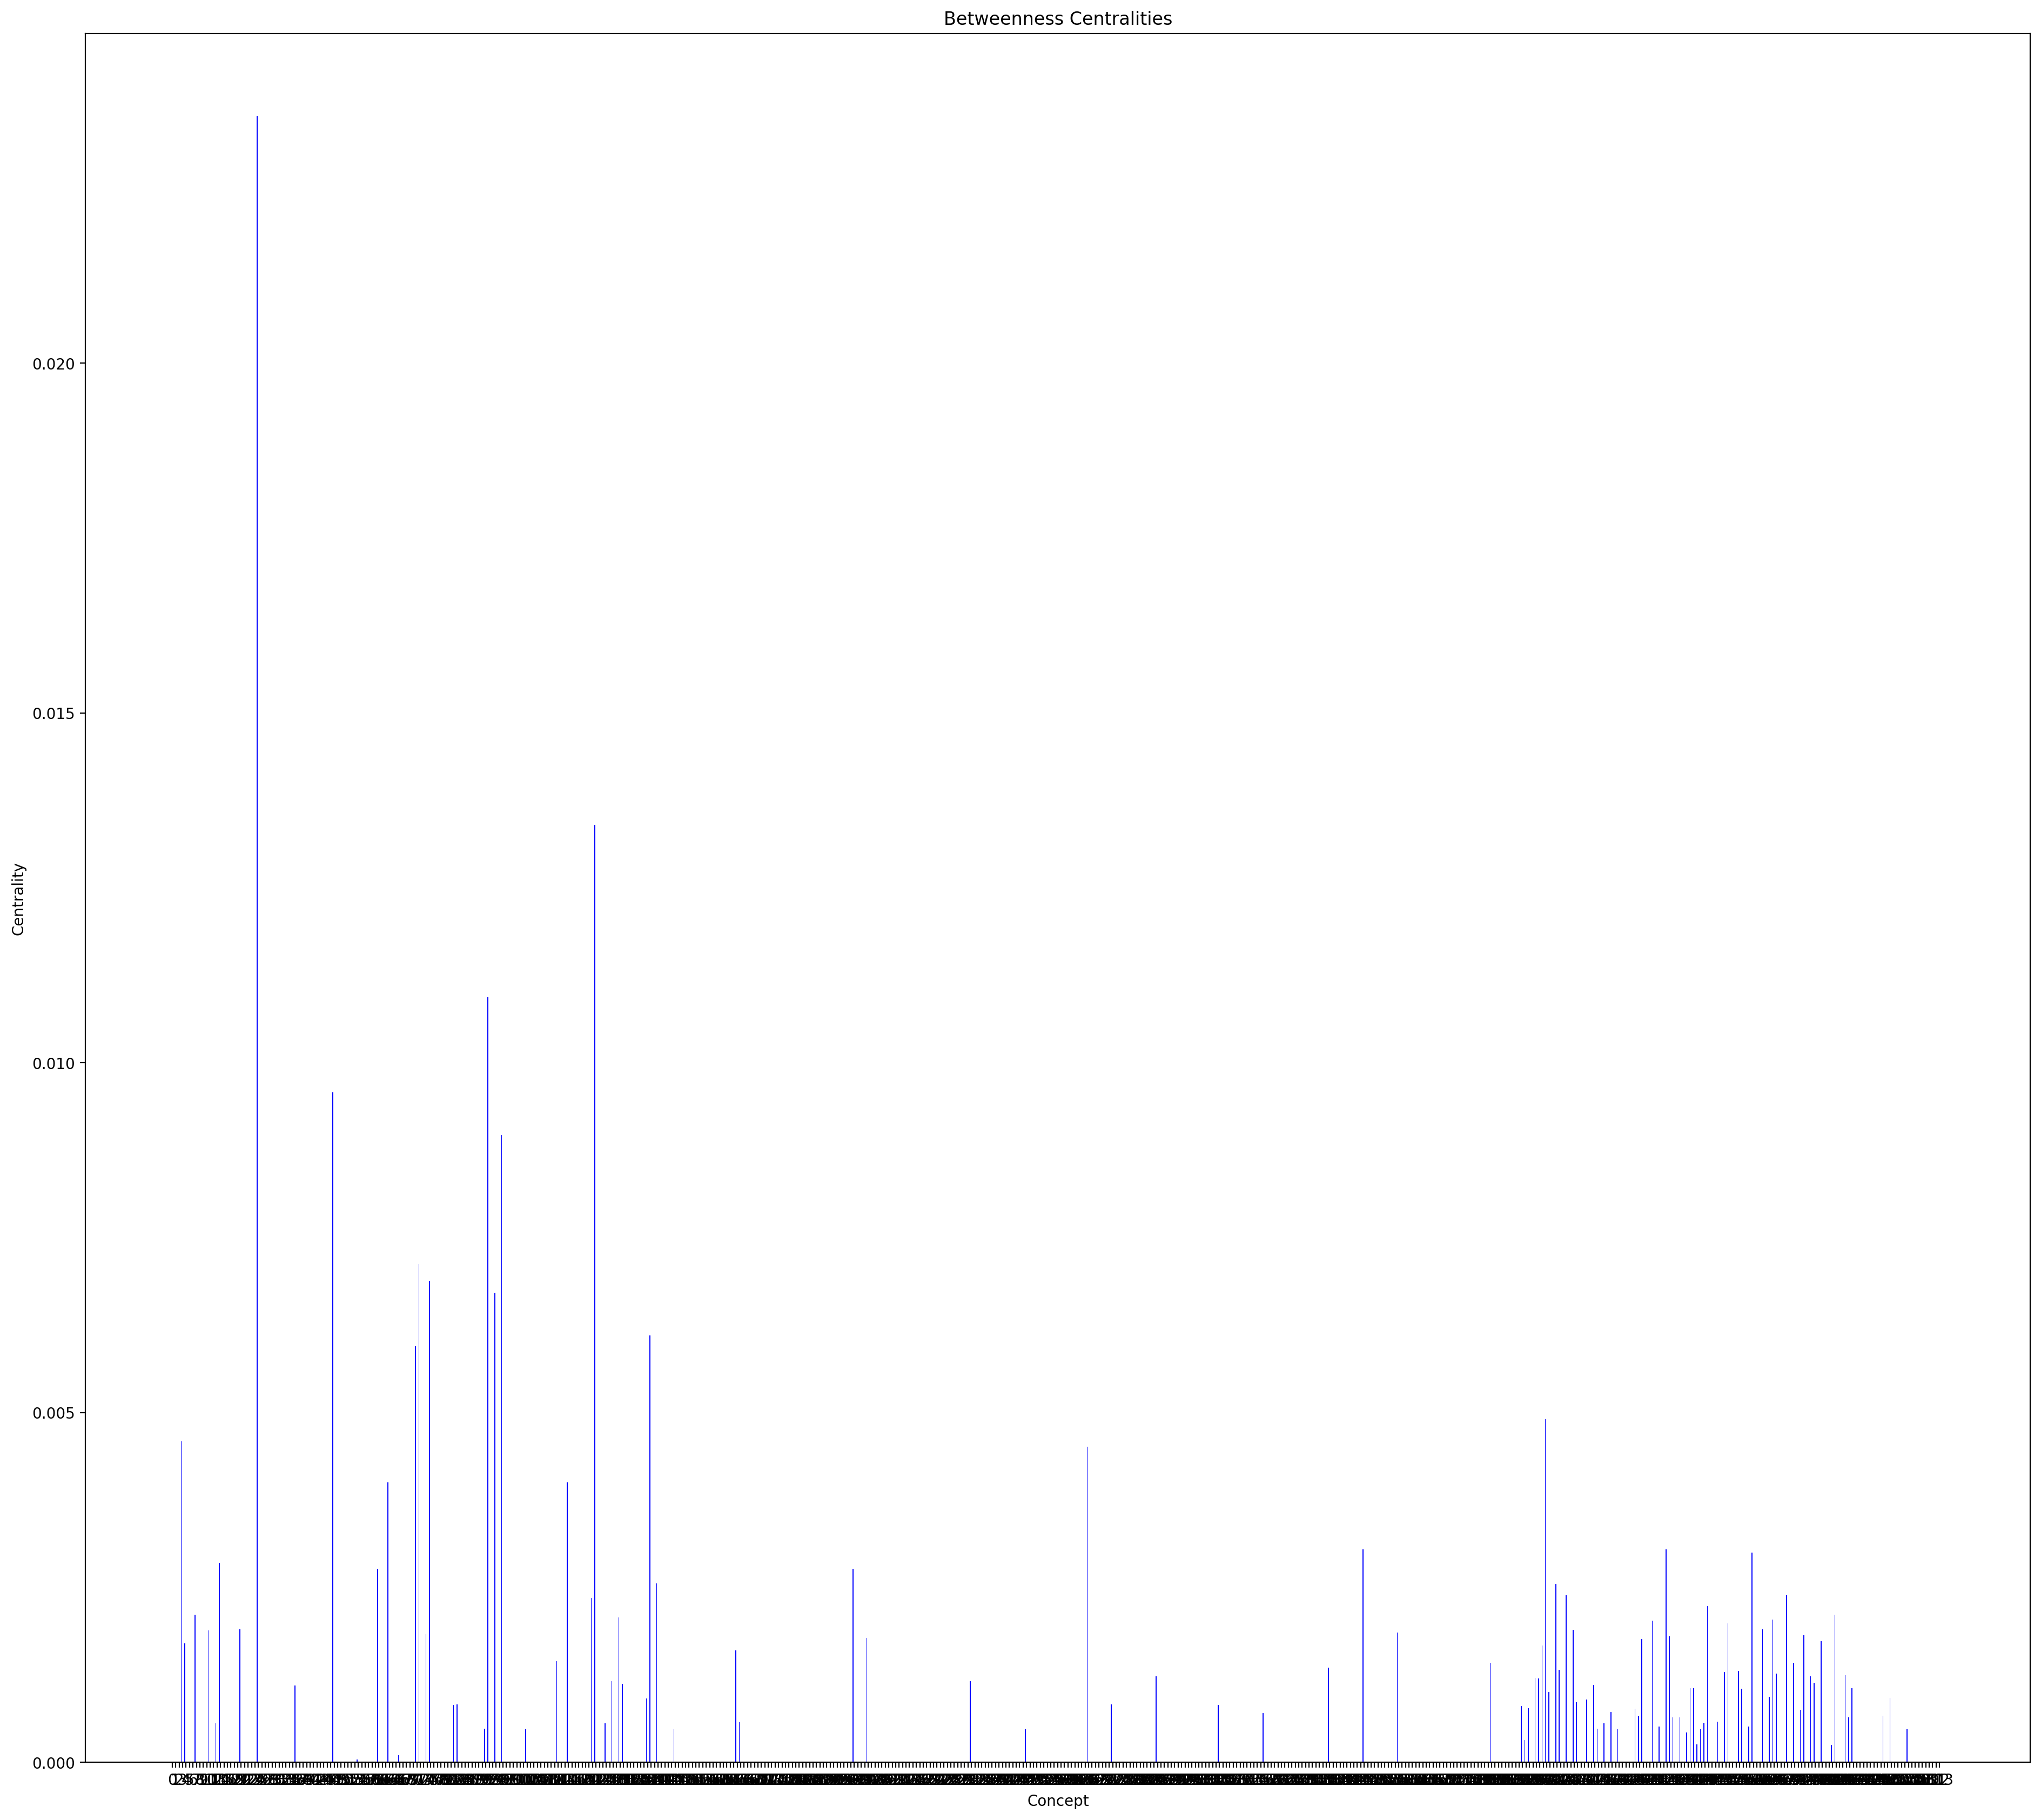

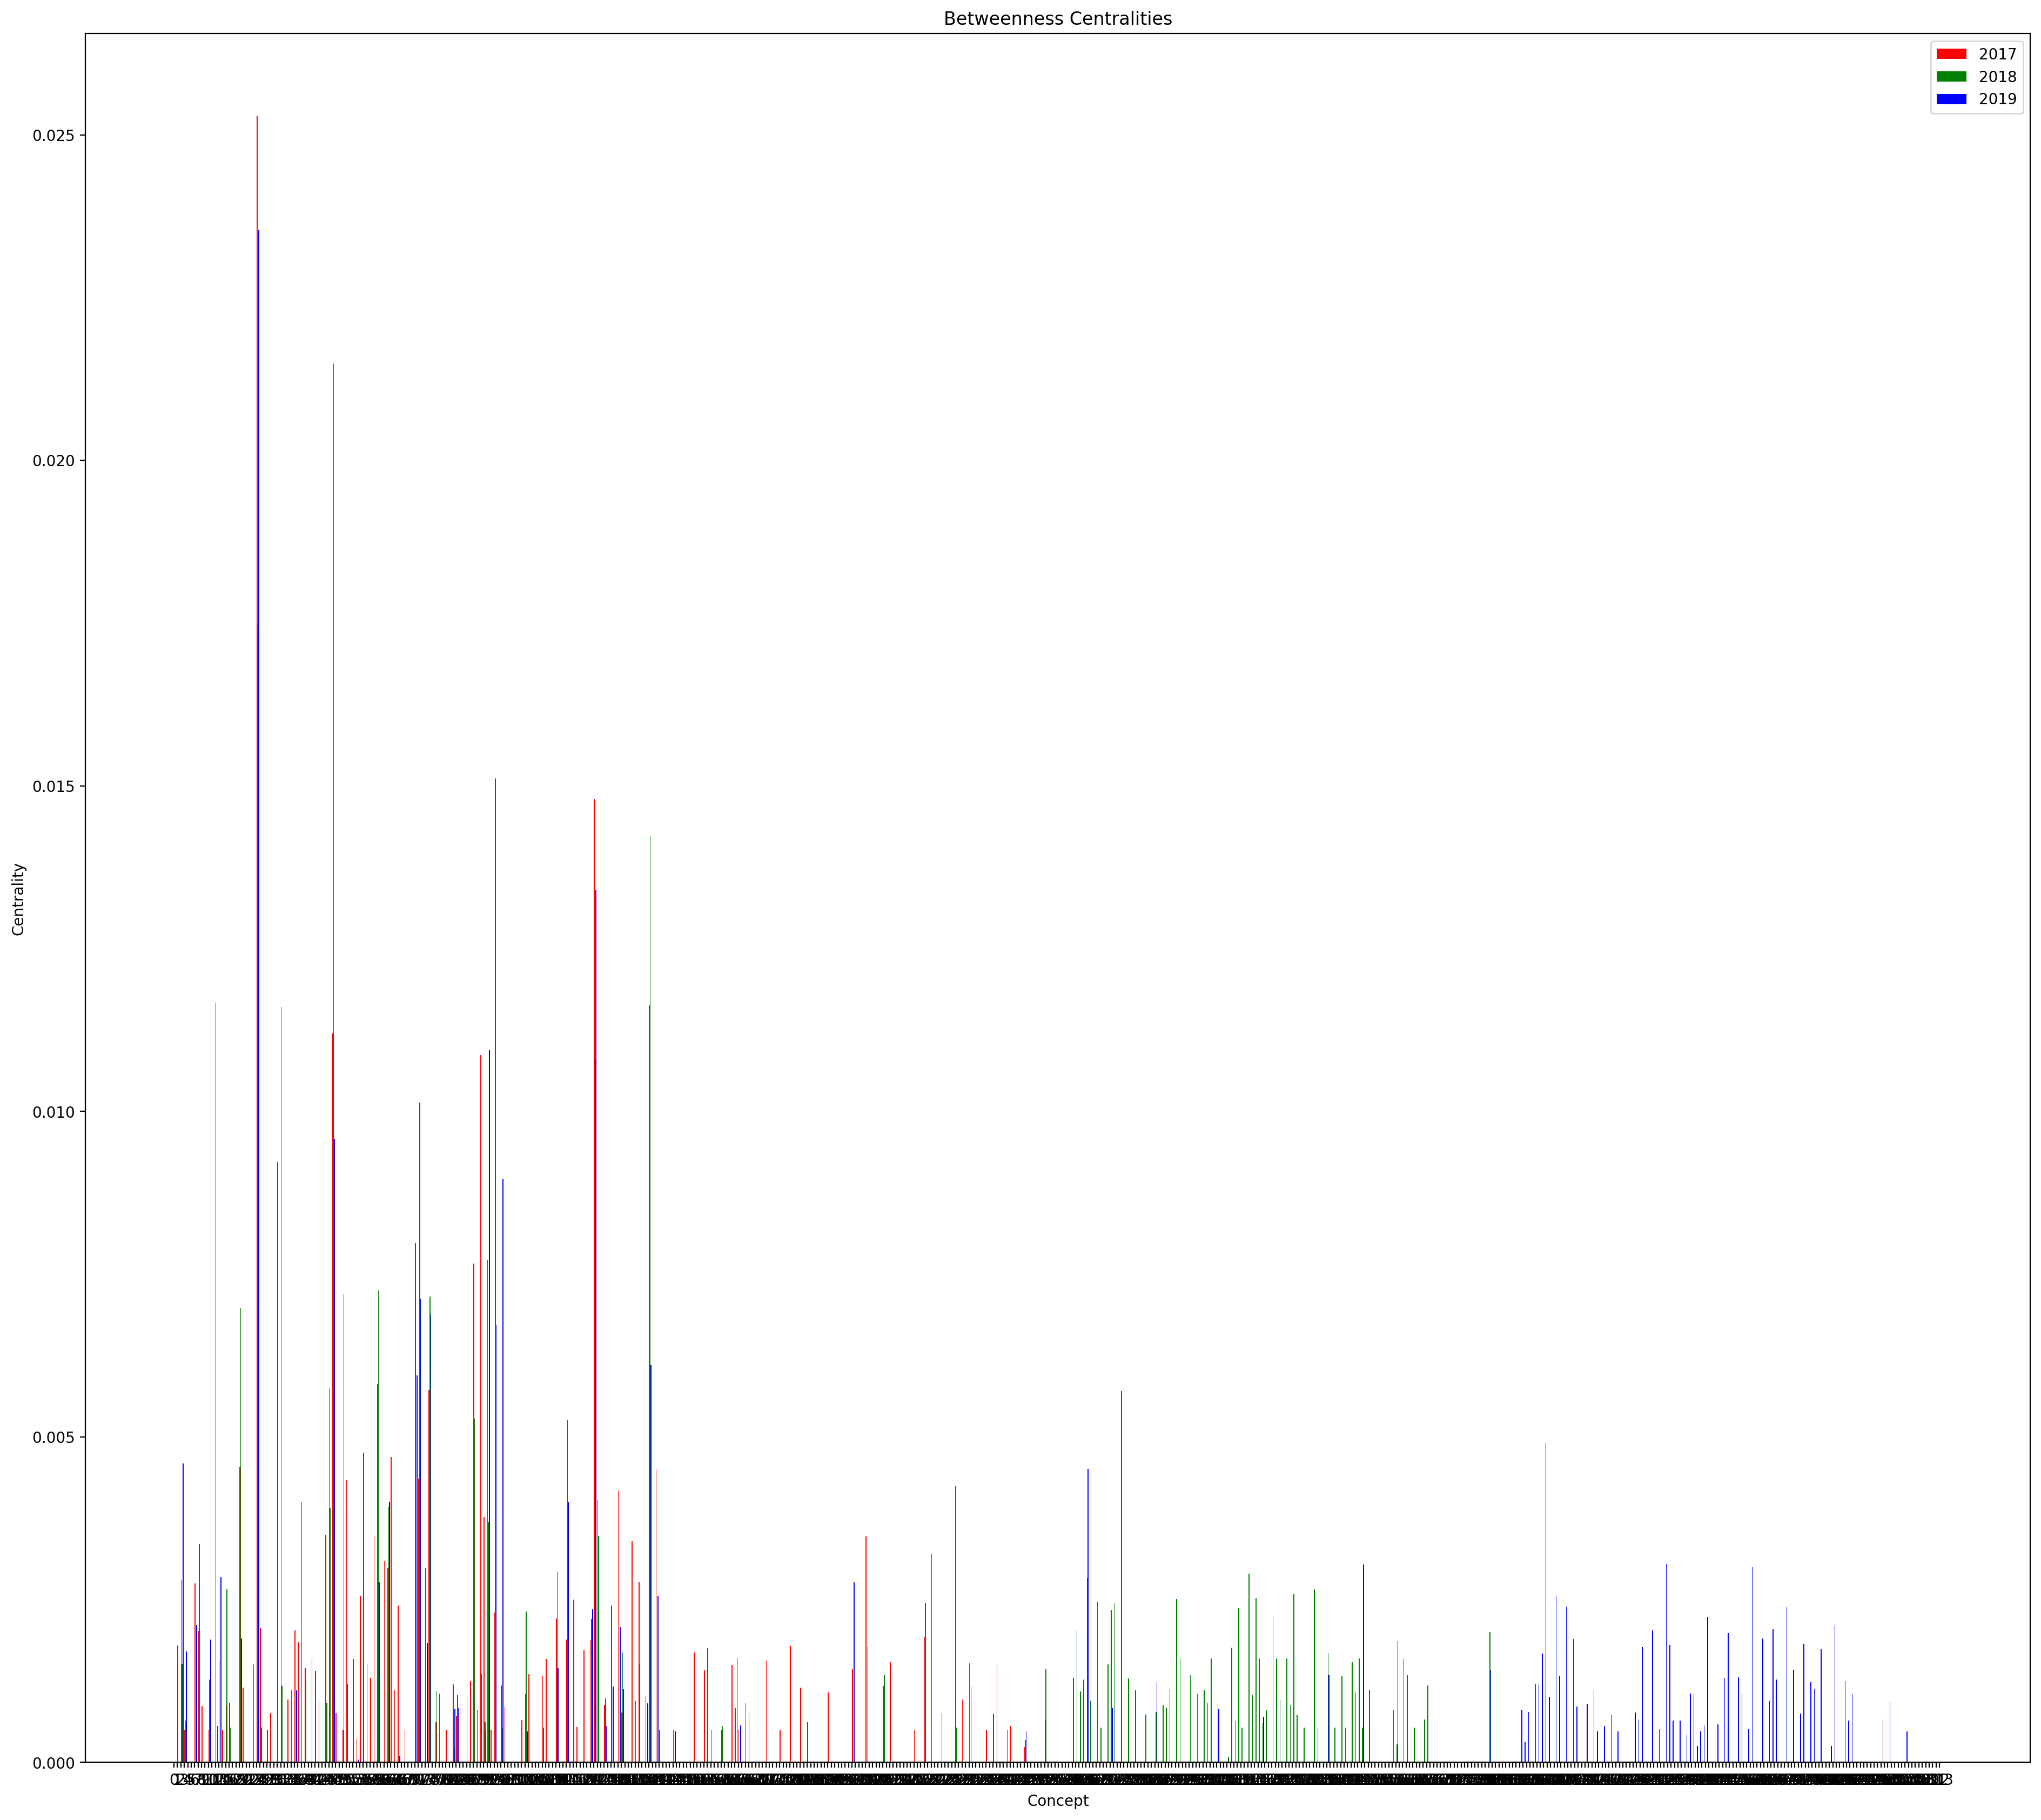

In [14]:
print('ALL BETWEENNESS CENTRALITIES')
plot_all(bet_centrality, 'Betweenness Centralities')

TOP BETWEENNESS CENTRALITIES
38
{rdflib.term.URIRef('http://local/local.owl#ontology'): [0.025287971961764973, 0.01747812388356752, 0.02353333264470635], rdflib.term.URIRef('http://local/local.owl#ontologies'): [0.014802080404017516, 0.010778475453609559, 0.013400419060244171], rdflib.term.URIRef('http://local/local.owl#description_logic'): [0.011670862738332592, 0, 0.0005616544401902651], rdflib.term.URIRef('http://local/local.owl#sparql'): [0.011629415763141374, 0.014229416603064846, 0.006103432114106642], rdflib.term.URIRef('http://local/local.owl#linked_data'): [0.011601707079704647, 0.0011748609207905575, 0], rdflib.term.URIRef('http://local/local.owl#rdf'): [0.011195367019267882, 0.02148839354084119, 0.009577681309261767], rdflib.term.URIRef('http://local/local.owl#social_media'): [0.01086557763228804, 0.001362178117505647, 0], rdflib.term.URIRef('http://local/local.owl#machine_translation'): [0.009223579542774469, 0, 0], rdflib.term.URIRef('http://local/local.owl#reasoning'): [0

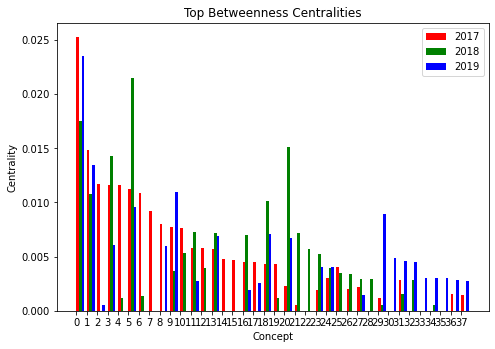

In [15]:
print('TOP BETWEENNESS CENTRALITIES')
print(len(top_bet_centrality))
print(top_bet_centrality)
plot_combined(top_bet_centrality, 'Top Betweenness Centralities')

BETWEENNESS CENTRALITY GRAPH EXAMPLES
Subgraph for level 3 neighbors of http://local/local.owl#ontology, in 2017:


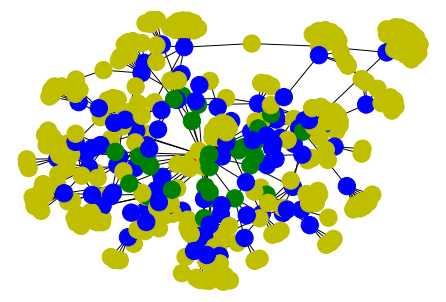

Subgraph for level 3 neighbors of http://local/local.owl#ontology, in 2018:


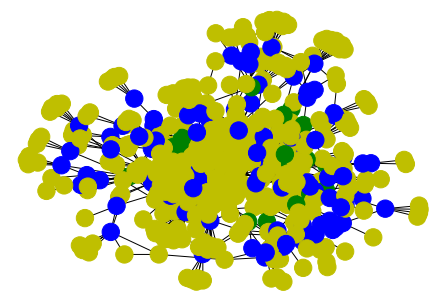

Subgraph for level 3 neighbors of http://local/local.owl#ontology, in 2019:


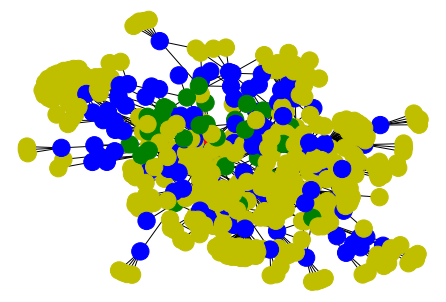

In [16]:
print('BETWEENNESS CENTRALITY GRAPH EXAMPLES')
for curr_year in nxgs.keys():
    for key in top_bet_centrality.keys():
        if 'ontology' in key:
            draw_subgraph(curr_year, key, neighborhood_level=3)
            break